#### Training

In [11]:
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import tqdm
from os.path import join as oj
from torchviz import make_dot
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Import MD-RNN from mdrnn.py
import rmdn
importlib.reload(rmdn)

# Import Utility Functions from utils.py
import utils
importlib.reload(utils)

# Import Dataset from decision_dataset.py
import decision_dataset
importlib.reload(decision_dataset)

# Determine device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Default training loop parameters
TRAINING_PARAMS = {
    'hidden_size': 32,
    'initial_learning_rate': 0.001,
    'min_lr': 1e-5,
    'num_epochs': 64,
    'batch_size': 64
}

2025-06-13 12:58:20,804 - INFO - Using device: cpu.
2025-06-13 12:58:20,807 - INFO - Using device: cpu.


cpu


#### Load and Test Dataloader

In [2]:
cache_folder = '../cache'

raw = pd.read_parquet(oj(cache_folder, 'RRM26-36_sleap_bdf.pq'))
df = raw[['animal', 'session', 'trial', 'offer_prob', 'slp_accept', 'quit', 'slp_tone_onset_time', 'slp_T_Entry_time', 'slp_choice_time', 'reward', 'restaurant']]
df.head(20)

animal session  trial  offer_prob  slp_accept         quit  \
0   RRM026  Day151      1         0.0         1.0          NaN   
1   RRM026  Day151      2        20.0         1.0          NaN   
2   RRM026  Day151      3         0.0         1.0          NaN   
3   RRM026  Day151      4        80.0         1.0          NaN   
4   RRM026  Day151      5        20.0         1.0          NaN   
5   RRM026  Day151      6        80.0         1.0          NaN   
6   RRM026  Day151      7        80.0         1.0          NaN   
7   RRM026  Day151      8        80.0         1.0          NaN   
8   RRM026  Day151      9       100.0         1.0          NaN   
9   RRM026  Day151     10       100.0         1.0          NaN   
10  RRM026  Day151     11        20.0         1.0          NaN   
11  RRM026  Day151     12       100.0         1.0          NaN   
12  RRM026  Day151     13         0.0         1.0          NaN   
13  RRM026  Day151     14        20.0         1.0          NaN   
14  RRM026  Day151     15        80.0         1.0          NaN   
15  RRM026  Day151     16        20.0         1.0          NaN   
16  RRM026  Day151     18        20.0         1.0  2759.080461   
17  RRM026  Day151     19         0.0         1.0          NaN   
18  RRM026  Day151     20        80.0         1.0          NaN   
19  RRM026  Day151     21       100.0         1.0          NaN   

    slp_tone_onset_time  slp_T_Entry_time  slp_choice_time  reward  restaurant  
0             45.860288         46.082765        46.216269       0           1  
1             71.315418         71.738138        72.305958       1           2  
2           1736.521459       1737.715123      1738.281459       0           3  
3           2006.501850       2008.432755      2009.333466       1           4  
4           2102.127718       2102.557427      2102.857869       0           1  
5           2388.594829       2389.659098      2389.991514       1           3  
6           2463.582246       2464.915827      2465.283162       0           4  
7           2487.729805       2488.497894      2488.896858       1           1  
8           2538.451878       2539.117926      2539.550938       1           2  
9           2579.608832       2580.175104      2580.509606       1           3  
10          2613.116352       2613.816883      2614.117594       0           4  
11          2644.242573       2645.175181      2645.811392       1           1  
12          2662.627443       2663.292019      2663.559757       0           2  
13          2682.197978       2682.960371      2683.227648       1           3  
14          2704.622438       2706.856666      2707.189069       1           4  
15          2728.171264       2728.703398      2728.971622       0           1  
16          2756.977664       2757.945357      2758.145178       0           3  
17          2772.633306       2773.131622      2773.398976       0           4  
18          2805.659072       2806.225331      2806.458803       1           1  
19          2829.181798       2833.252762      2833.619814       1           2

2025-06-11 18:35:19,064 - INFO - Initialized Dataset in LOAD mode.
2025-06-11 18:35:19,117 - WARNING - Warning: Skipping trial RRM026_Day151_45 due to NaN in critical timing column(s).
2025-06-11 18:35:19,119 - WARNING - Warning: Skipping trial RRM026_Day151_64 due to NaN in critical timing column(s).
2025-06-11 18:35:19,119 - WARNING - Warning: Skipping trial RRM026_Day151_66 due to NaN in critical timing column(s).
2025-06-11 18:35:19,122 - WARNING - Warning: Skipping trial RRM026_Day160_76 due to NaN in critical timing column(s).
2025-06-11 18:35:19,133 - WARNING - Warning: Skipping trial RRM026_Day167_46 due to NaN in critical timing column(s).
2025-06-11 18:35:19,135 - WARNING - Warning: Skipping trial RRM026_Day167_90 due to NaN in critical timing column(s).
2025-06-11 18:35:19,138 - WARNING - Warning: Skipping trial RRM026_Day167_172 due to NaN in critical timing column(s).
2025-06-11 18:35:19,142 - WARNING - Warning: Skipping trial RRM026_Day172_96 due to NaN in critical timing

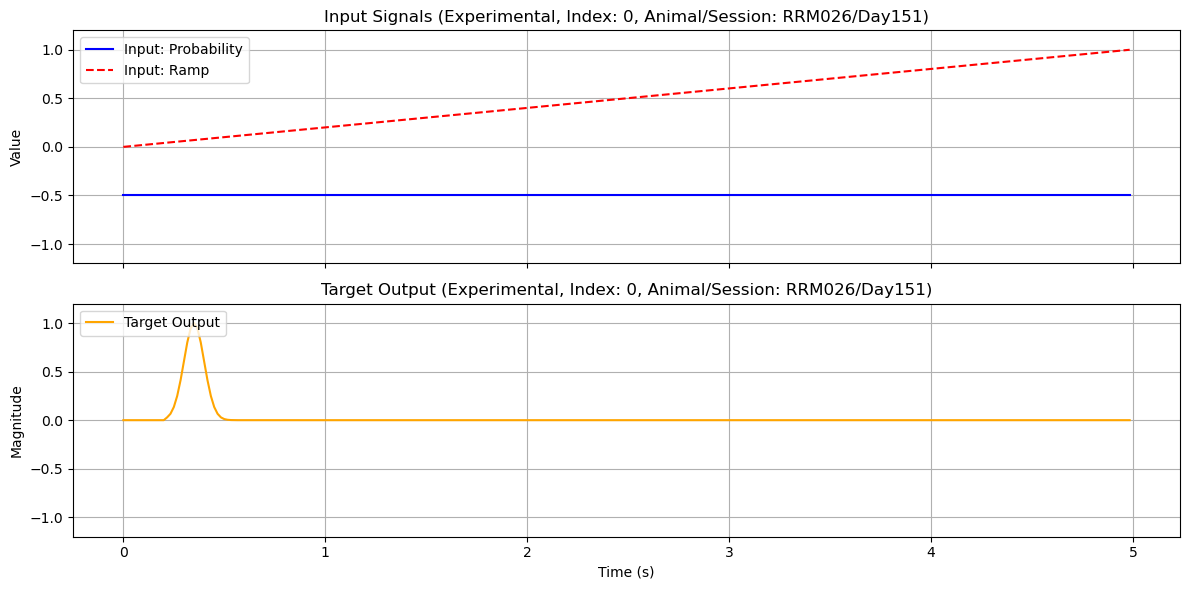

In [3]:
dataset = decision_dataset.DecisionDataset(generate=False, df=df)
#dataset = decision_dataset.DecisionDataset(generate=True, num_samples=8192)
dataset.plot_trial()

dataloader = DataLoader(dataset,
                        batch_size=TRAINING_PARAMS['batch_size'],
                        shuffle=True)


--- Analysis for offer_prob = 0.0 ---


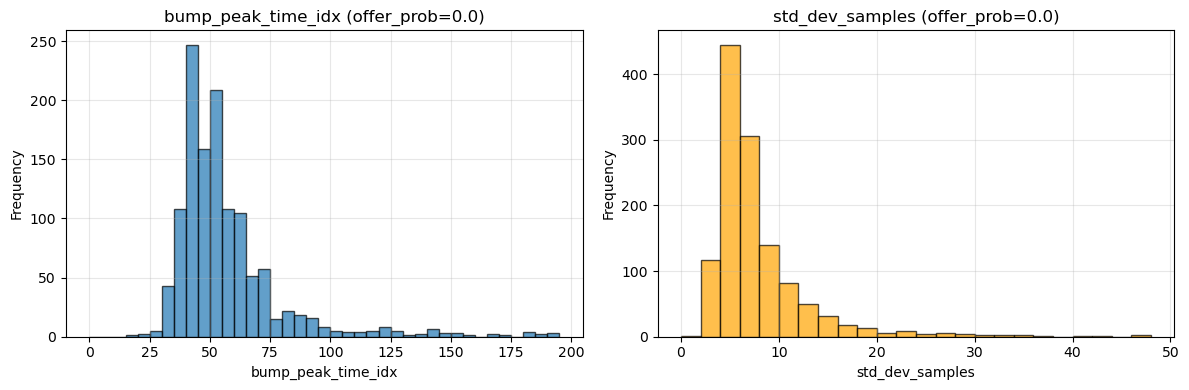

Average slp_accept: 0.1630

Descriptive statistics:

bump_peak_time_idx:
count    1258.000000
mean       60.625596
std        38.766468
min        18.000000
25%        42.000000
50%        50.000000
75%        62.000000
max       299.000000
Name: bump_peak_time_idx, dtype: float64

std_dev_samples:
count    1258.000000
mean        8.844197
std        15.976849
min         1.000000
25%         5.000000
50%         6.000000
75%         9.000000
max       336.000000
Name: std_dev_samples, dtype: float64

slp_accept:
count    1258.000000
mean        0.162957
std         0.369473
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: slp_accept, dtype: float64

--- Analysis for offer_prob = 20.0 ---


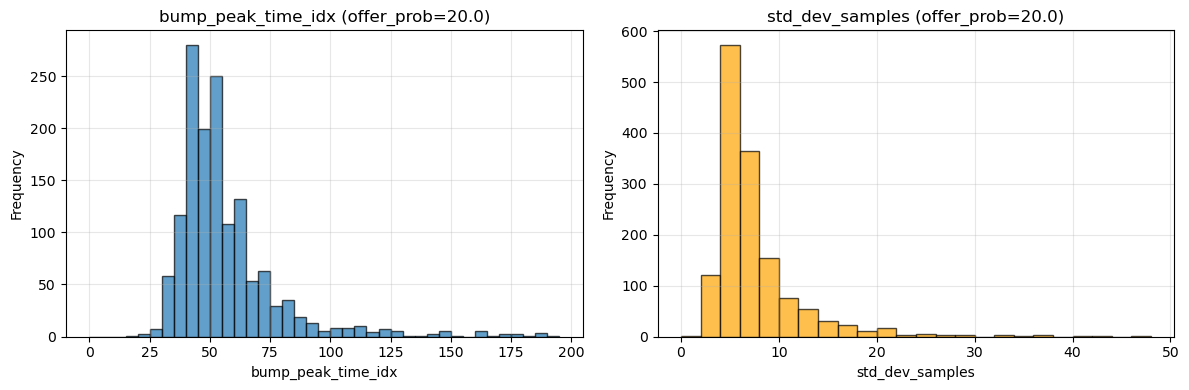

Average slp_accept: 0.4437

Descriptive statistics:

bump_peak_time_idx:
count    1465.000000
mean       59.589078
std        35.868542
min        18.000000
25%        42.000000
50%        50.000000
75%        62.000000
max       299.000000
Name: bump_peak_time_idx, dtype: float64

std_dev_samples:
count    1465.000000
mean        7.900341
std         9.068103
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max       157.000000
Name: std_dev_samples, dtype: float64

slp_accept:
count    1465.000000
mean        0.443686
std         0.496988
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: slp_accept, dtype: float64

--- Analysis for offer_prob = 80.0 ---


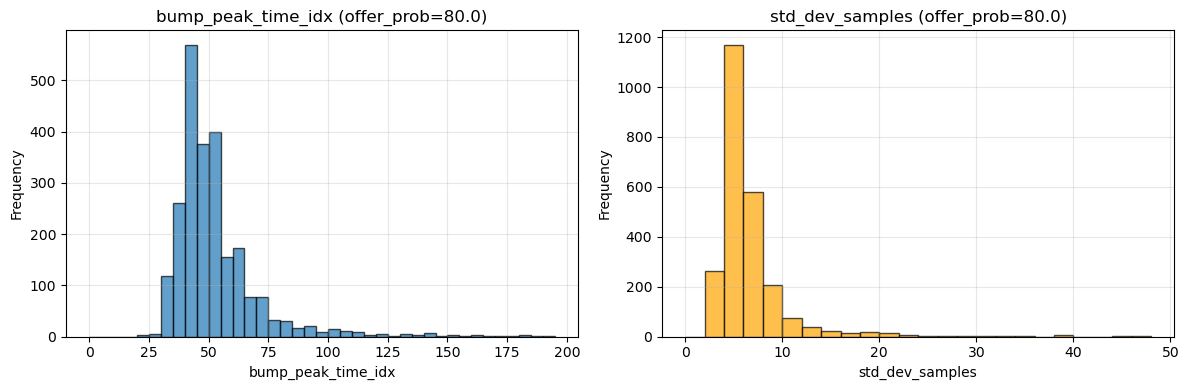

Average slp_accept: 0.8204

Descriptive statistics:

bump_peak_time_idx:
count    2445.000000
mean       55.580777
std        32.263639
min        20.000000
25%        42.000000
50%        48.000000
75%        58.000000
max       299.000000
Name: bump_peak_time_idx, dtype: float64

std_dev_samples:
count    2445.000000
mean        6.890389
std        10.229059
min         2.000000
25%         4.000000
50%         5.000000
75%         7.000000
max       243.000000
Name: std_dev_samples, dtype: float64

slp_accept:
count    2445.000000
mean        0.820450
std         0.383891
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: slp_accept, dtype: float64

--- Analysis for offer_prob = 100.0 ---


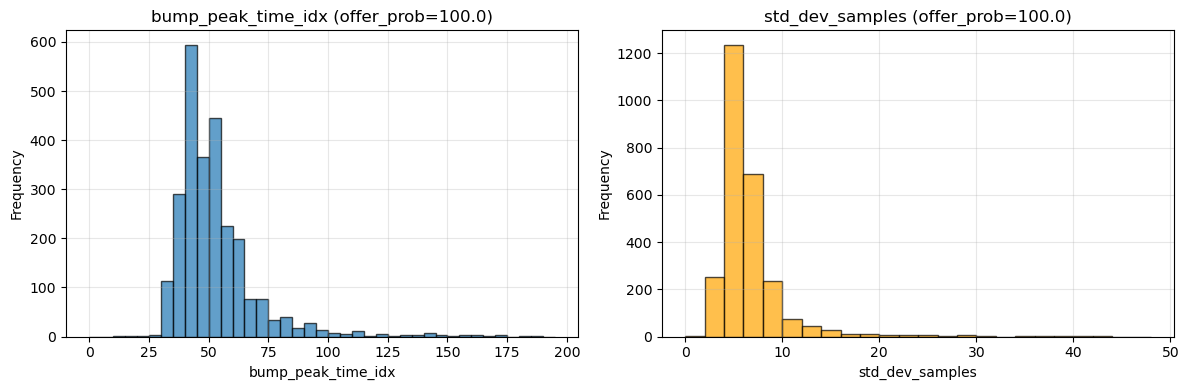

Average slp_accept: 0.8955

Descriptive statistics:

bump_peak_time_idx:
count    2623.000000
mean       54.947388
std        30.292074
min        14.000000
25%        42.000000
50%        48.000000
75%        58.000000
max       299.000000
Name: bump_peak_time_idx, dtype: float64

std_dev_samples:
count    2623.000000
mean        6.559283
std         7.897381
min         1.000000
25%         4.500000
50%         5.000000
75%         7.000000
max       198.000000
Name: std_dev_samples, dtype: float64

slp_accept:
count    2623.000000
mean        0.895539
std         0.305915
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: slp_accept, dtype: float64


In [8]:
exp_df = dataset.df

def analysis(df):
    """
    Manual step-by-step analysis
    """
    grouped = df.groupby('offer_prob')
    
    for prob_value, group in grouped:
        print(f"\n--- Analysis for offer_prob = {prob_value} ---")
        
        # Histograms
        plt.figure(figsize=(12, 4))

        bump_bins = np.arange(0,200,5)
        std_bins = np.arange(0,50,2)
        
        plt.subplot(1, 2, 1)
        plt.hist(group['bump_peak_time_idx'].dropna(), bins=bump_bins, alpha=0.7, edgecolor='black')
        plt.title(f'bump_peak_time_idx (offer_prob={prob_value})')
        plt.xlabel('bump_peak_time_idx')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.hist(group['std_dev_samples'].dropna(), bins=std_bins, alpha=0.7, edgecolor='black', color='orange')
        plt.title(f'std_dev_samples (offer_prob={prob_value})')
        plt.xlabel('std_dev_samples')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Average of slp_accept
        print(f"Average slp_accept: {group['slp_accept'].mean():.4f}")
        
        # Descriptive statistics
        print("\nDescriptive statistics:")
        for col in ['bump_peak_time_idx', 'std_dev_samples', 'slp_accept']:
            print(f"\n{col}:")
            print(group[col].describe())

analysis(exp_df)

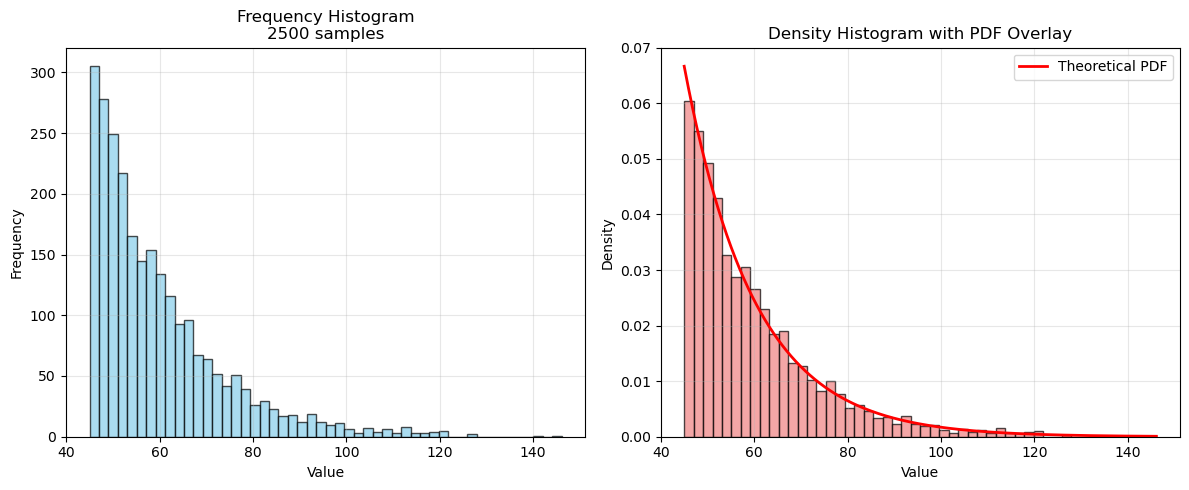

array([76.7954667 , 47.45857376, 65.47782896, ..., 45.68930907,
       49.81862563, 55.23170356])

In [14]:
def plot_exponential_samples(n_samples=2500, scale=15, shift=45, bins=50):
    """
    Generate and plot simplified histogram of exponential distribution samples
    
    Parameters:
    - n_samples: number of samples to generate
    - scale: scale parameter of exponential distribution
    - shift: shift parameter (added to exponential samples)
    - bins: number of histogram bins
    """
    # Generate samples
    samples = np.random.exponential(scale, n_samples) + shift
    
    # Create plot
    plt.figure(figsize=(12, 5))
    
    # Standard histogram
    plt.subplot(1, 2, 1)
    plt.hist(samples, bins=bins, alpha=0.7, edgecolor='black', color='skyblue')
    plt.title(f'Frequency Histogram\n{n_samples} samples')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Density histogram with PDF overlay
    plt.subplot(1, 2, 2)
    plt.hist(samples, bins=bins, alpha=0.7, edgecolor='black', color='lightcoral', density=True)
    
    # Theoretical PDF overlay
    x_theory = np.linspace(shift, np.max(samples), 1000)
    y_theory = stats.expon.pdf(x_theory - shift, scale=scale)
    plt.plot(x_theory, y_theory, 'r-', linewidth=2, label='Theoretical PDF')
    
    plt.title('Density Histogram with PDF Overlay')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return samples

plot_exponential_samples()

#### Training Pass

In [4]:
def visualize_mixture_components(pi, mu, sigma, output, time, prob):
    fig, axes = plt.subplot_mosaic([['a)', 'b)', 'c)'], ['d)', 'e)', 'e)']], layout='constrained')
    
    fig.suptitle(f'Mixture Density Output, Probability = {prob}')

    pi = pi.squeeze(0)
    mu = mu.squeeze(0).squeeze(-1)
    sigma = sigma.squeeze(0).squeeze(-1)
    output = output.squeeze(0).squeeze(-1)[:-1]

    axes['a)'].plot(time, mu[:, 0], label=rf'$\mu$', color='blue')
    axes['a)'].fill_between(time, mu[:, 0] - sigma[:, 0], mu[:, 0] + sigma[:, 0], color='blue', alpha=0.3, label=rf'$\mu \pm \sigma$')
    axes['a)'].set_title('Gaussian One')

    axes['b)'].plot(time, mu[:, 1], label=rf'$\mu$', color='blue')
    axes['b)'].fill_between(time, mu[:, 1] - sigma[:, 1], mu[:, 1] + sigma[:, 1], color='blue', alpha=0.3, label=rf'$\mu \pm \sigma$')
    axes['b)'].set_title('Gaussian Two')

    axes['c)'].plot(time, mu[:, 2], label=rf'$\mu$', color='blue')
    axes['c)'].fill_between(time, mu[:, 2] - sigma[:, 2], mu[:, 2] + sigma[:, 2], color='blue', alpha=0.3, label=rf'$\mu \pm \sigma$')
    axes['c)'].set_title('Gaussian Three')

    axes['d)'].plot(time, pi[:, 0], label='Mixture One')
    axes['d)'].plot(time, pi[:, 1], label='Mixture Two')
    axes['d)'].plot(time, pi[:, 2], label='Mixture Three')
    axes['d)'].set_title('Mixture Weights')
    axes['d)'].legend()

    axes['e)'].plot(time, output, label='Output')
    axes['e)'].set_title('Output')

    plt.show()


Training Progress:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/64, Loss: 1.1208


Epoch 2/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/64, Loss: 0.4693


Epoch 3/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/64, Loss: -0.4803


Epoch 4/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/64, Loss: -1.0193


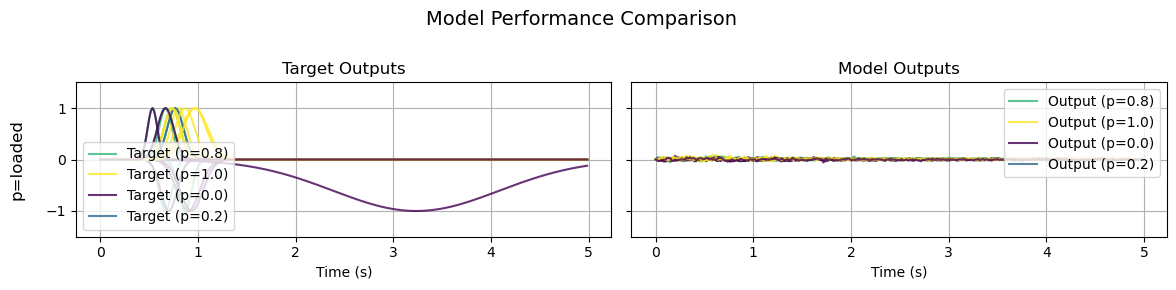

2025-06-11 18:37:51,509 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


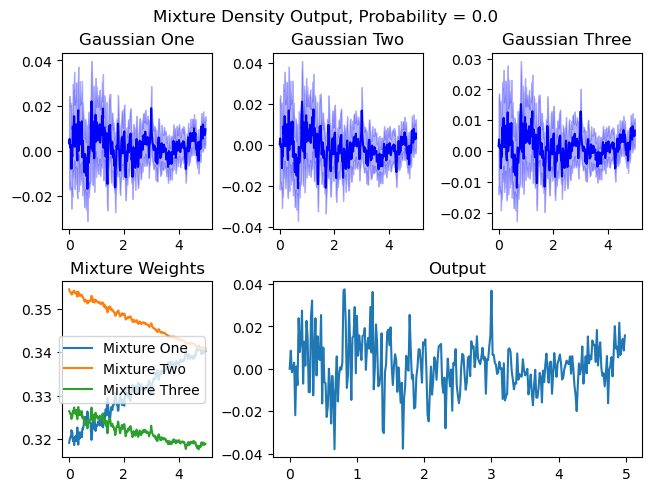

torch.Size([300, 2])


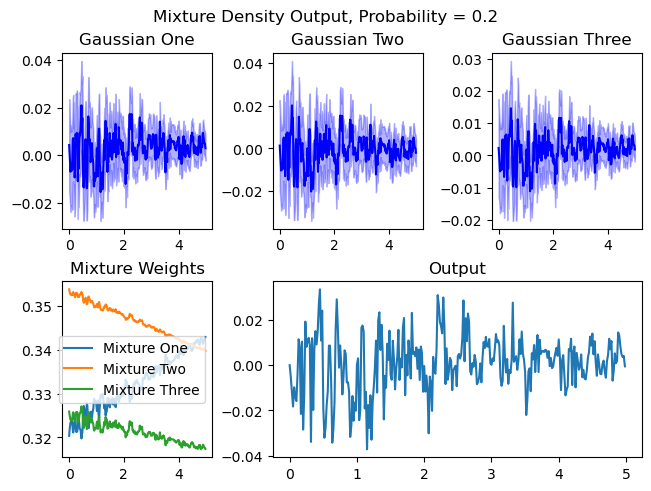

torch.Size([300, 2])


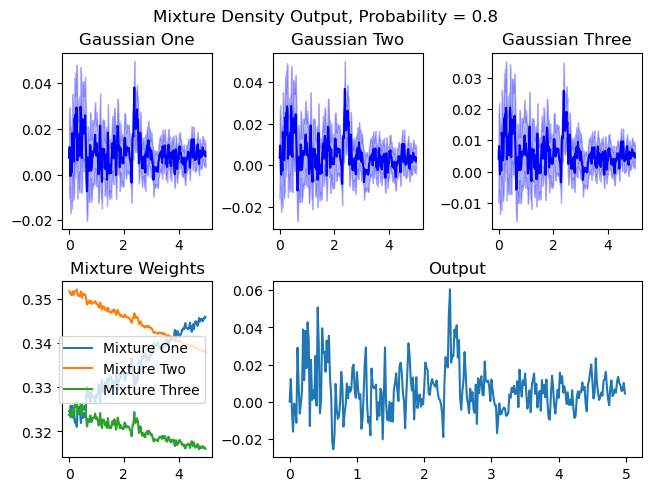

torch.Size([300, 2])


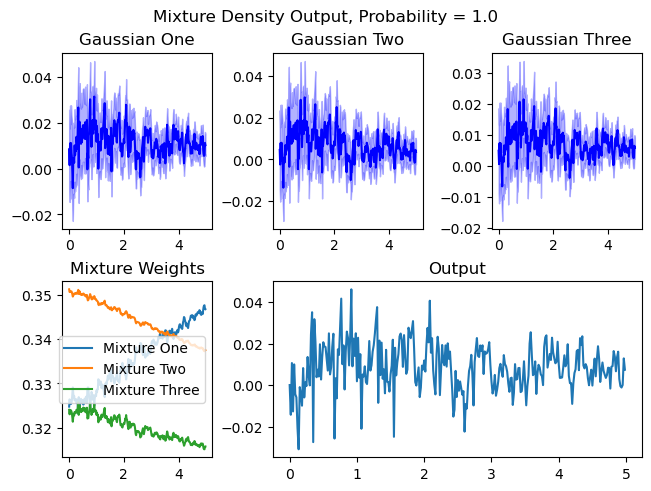

Epoch 5/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/64, Loss: -1.6934


Epoch 6/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/64, Loss: -1.9249


Epoch 7/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/64, Loss: -2.0508


Epoch 8/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/64, Loss: -2.2833


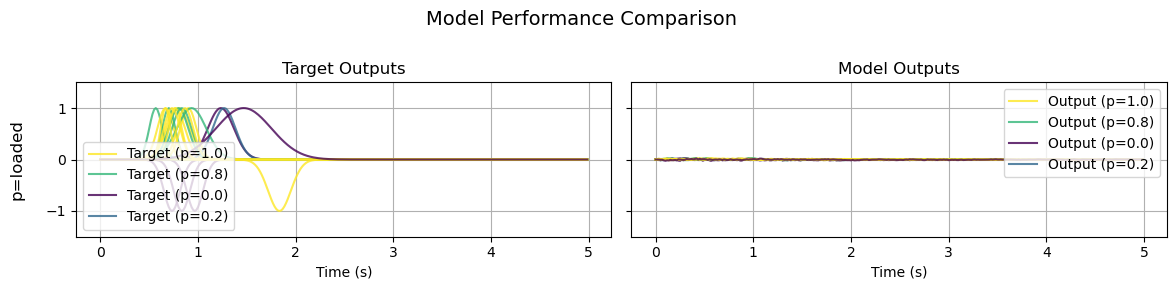

2025-06-11 18:40:21,119 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


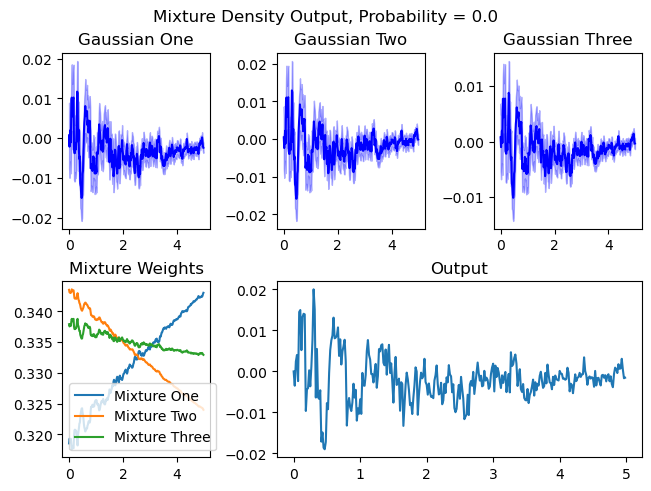

torch.Size([300, 2])


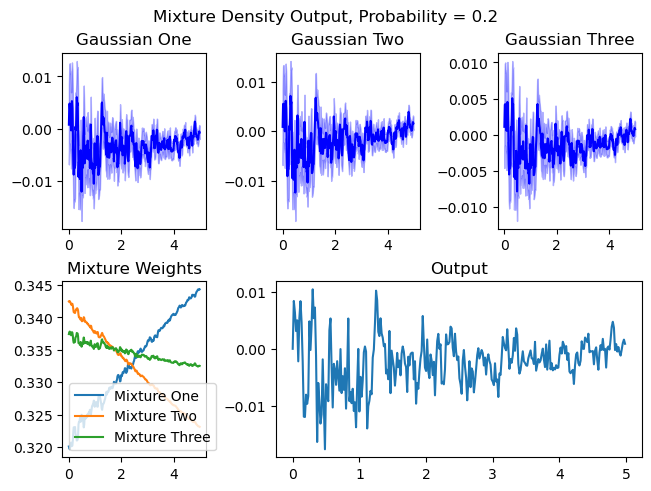

torch.Size([300, 2])


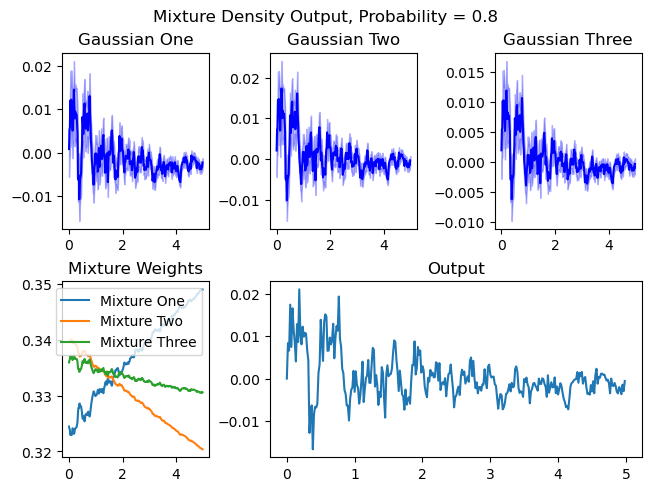

torch.Size([300, 2])


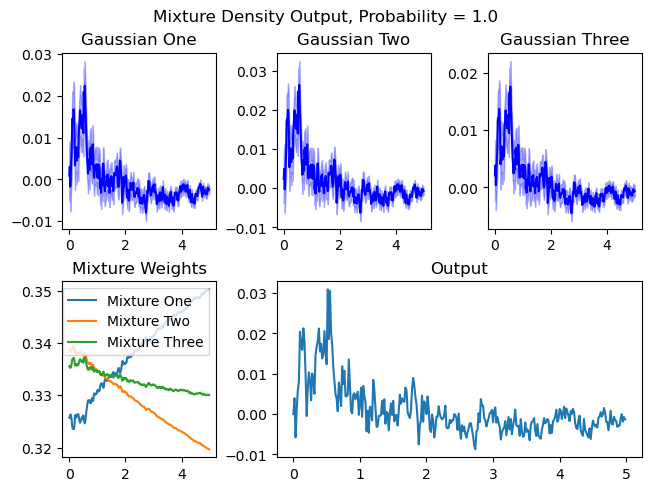

Epoch 9/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/64, Loss: -2.3670


Epoch 10/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/64, Loss: -2.4593


Epoch 11/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/64, Loss: -2.5094


Epoch 12/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/64, Loss: -2.5362


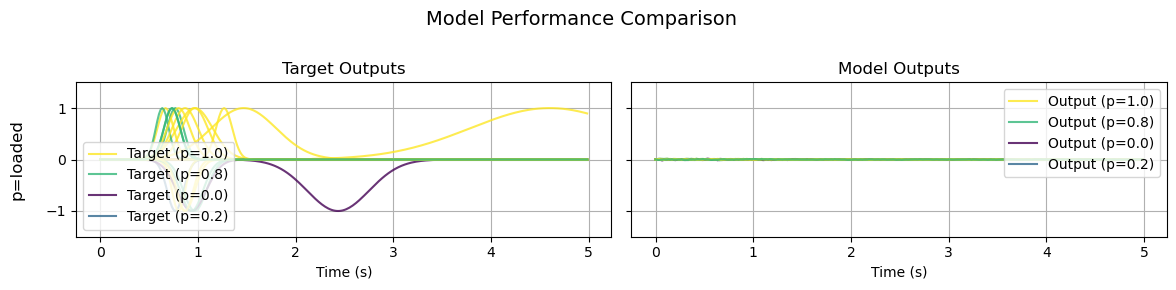

2025-06-11 18:42:47,764 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


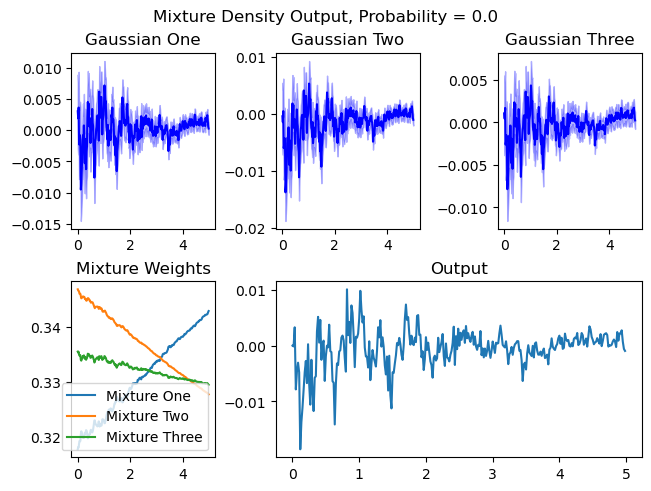

torch.Size([300, 2])


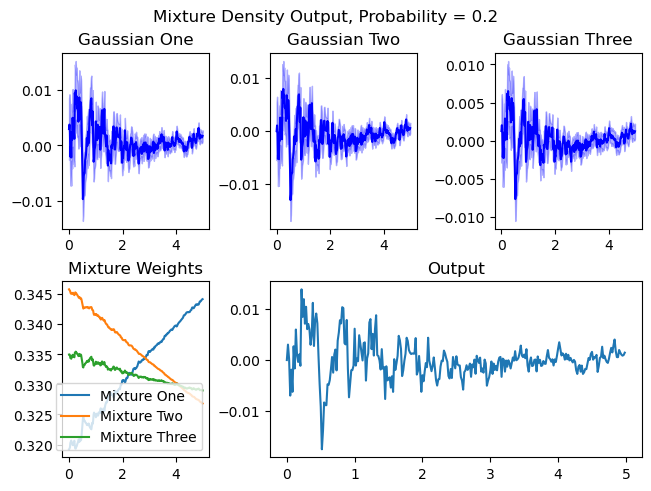

torch.Size([300, 2])


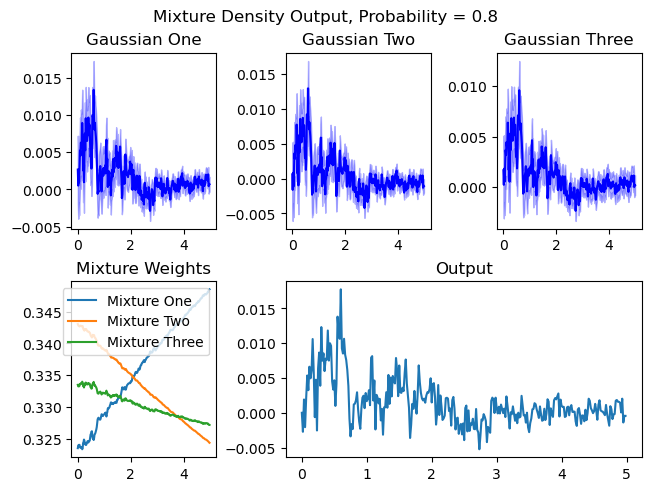

torch.Size([300, 2])


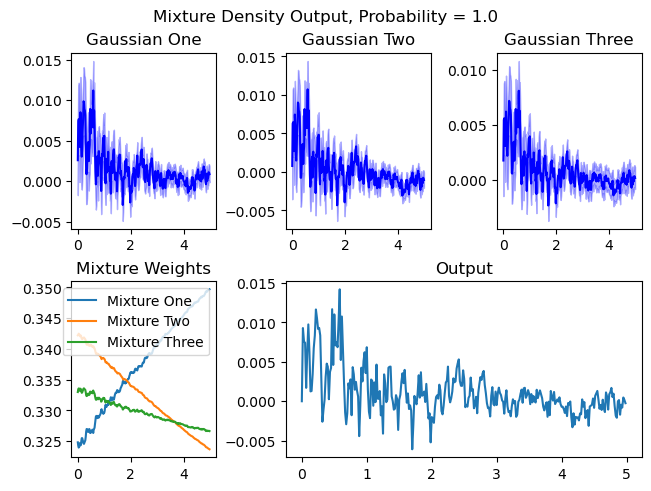

Epoch 13/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/64, Loss: -2.5471


Epoch 14/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/64, Loss: -2.5820


Epoch 15/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/64, Loss: -2.5744


Epoch 16/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/64, Loss: -2.5772


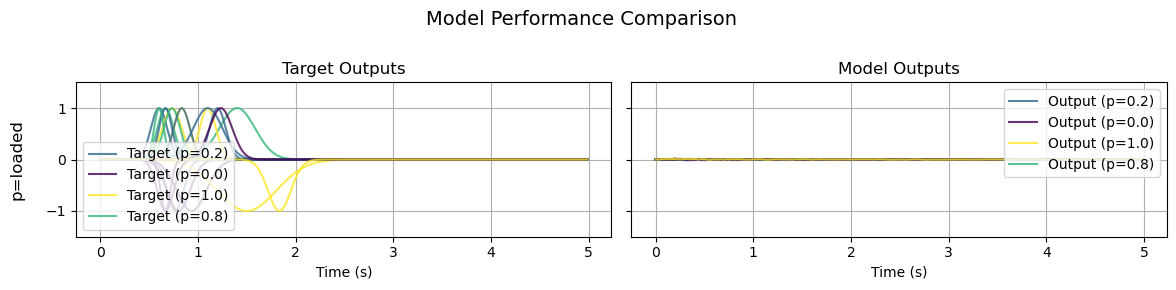

2025-06-11 18:45:14,588 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


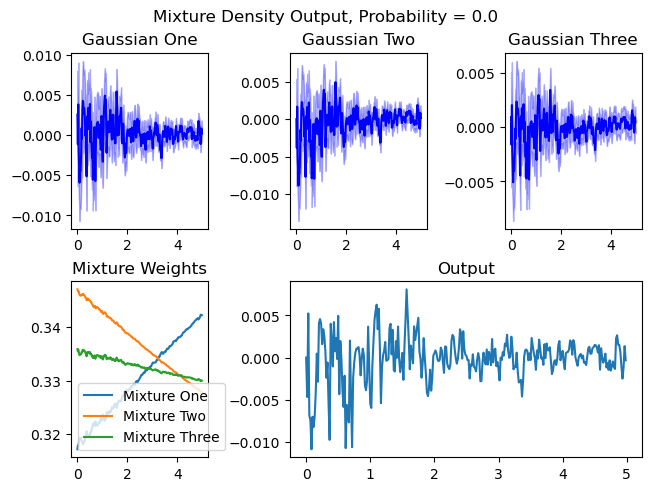

torch.Size([300, 2])


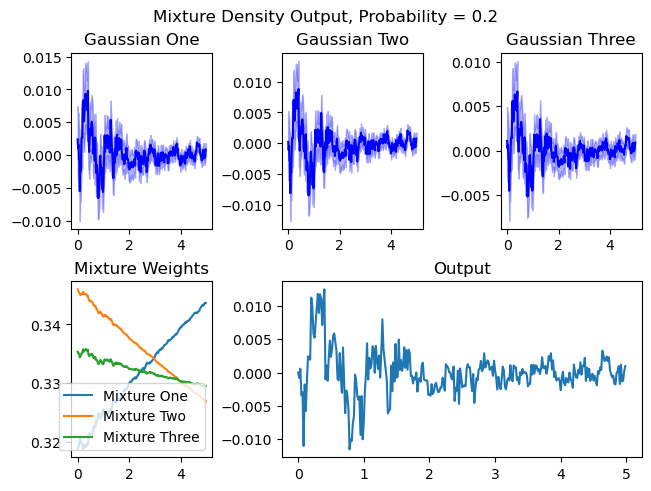

torch.Size([300, 2])


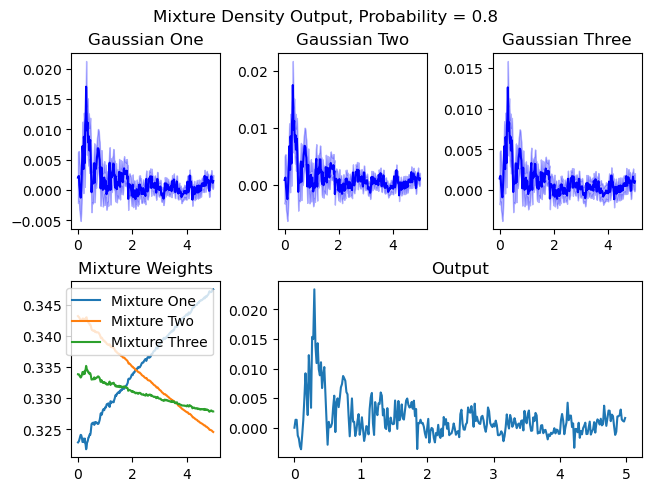

torch.Size([300, 2])


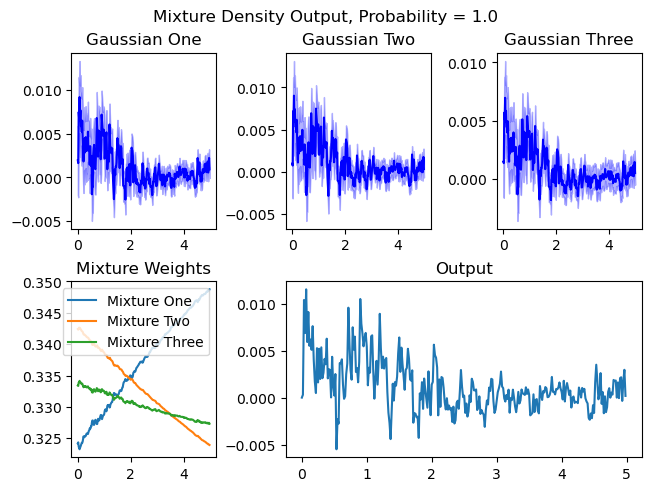

Epoch 17/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/64, Loss: -1.1555


Epoch 18/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/64, Loss: -2.0264


Epoch 19/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/64, Loss: -2.0658


Epoch 20/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/64, Loss: -1.7910


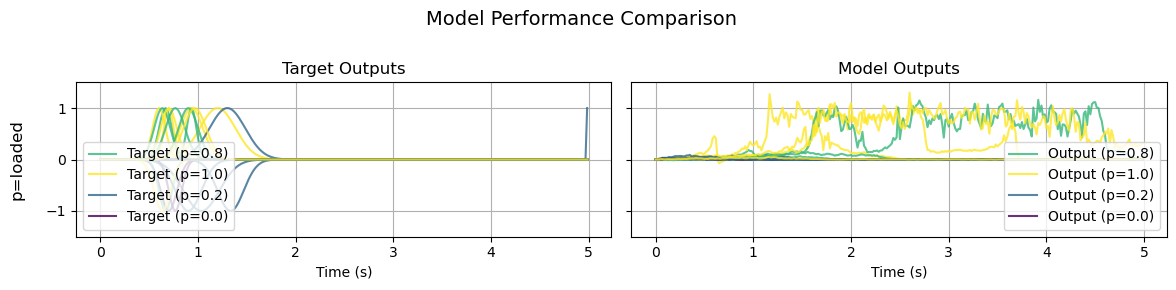

2025-06-11 18:47:40,967 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


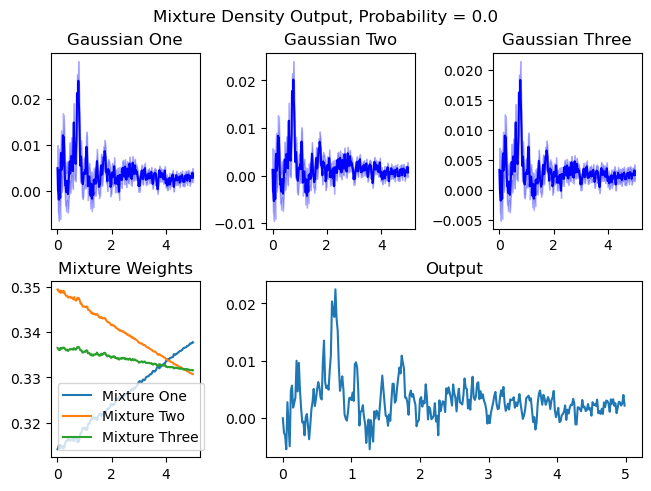

torch.Size([300, 2])


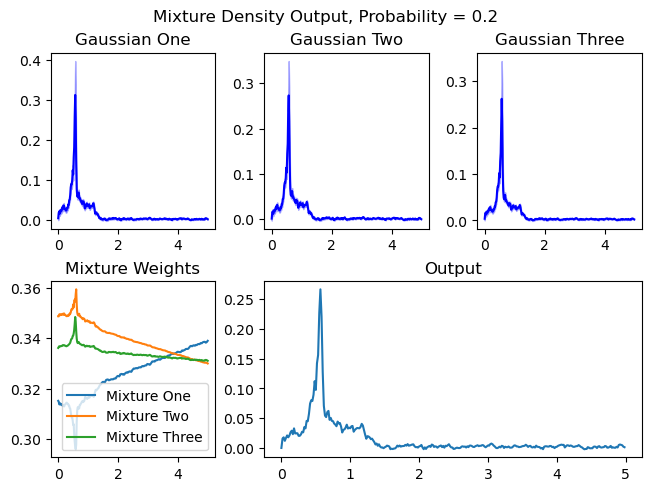

torch.Size([300, 2])


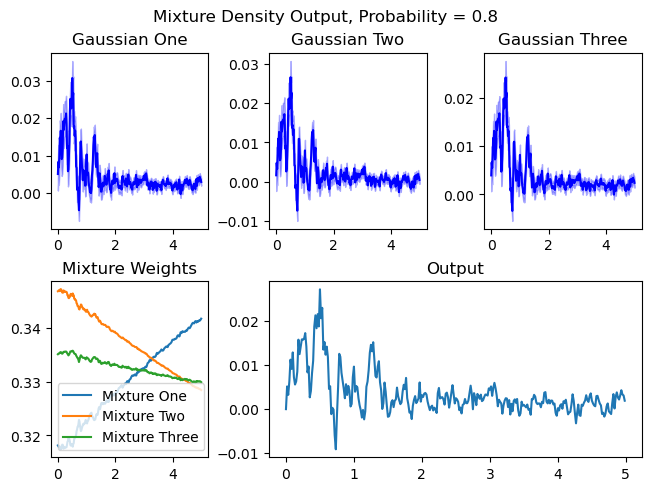

torch.Size([300, 2])


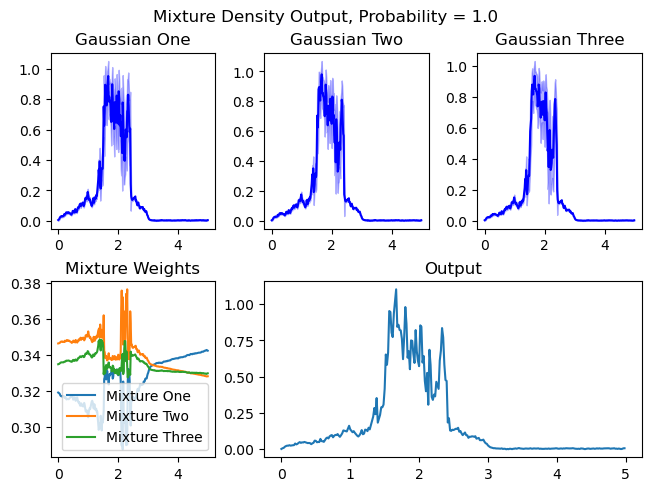

Epoch 21/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 21/64, Loss: -1.2941


Epoch 22/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 22/64, Loss: -1.6948


Epoch 23/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 23/64, Loss: -2.2241


Epoch 24/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 24/64, Loss: -2.1420


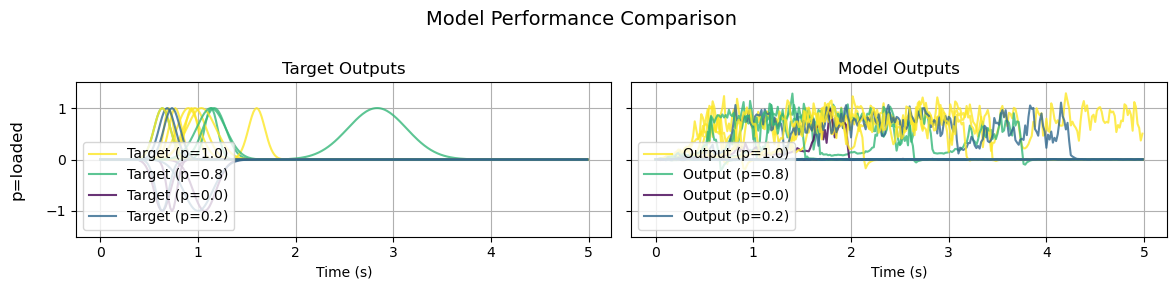

2025-06-11 18:50:16,353 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


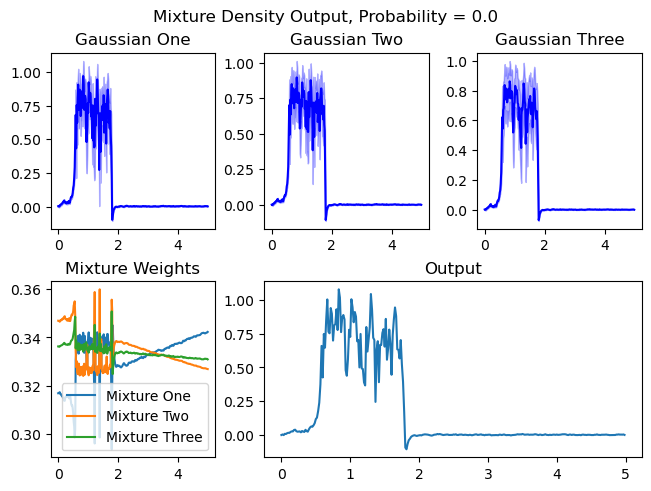

torch.Size([300, 2])


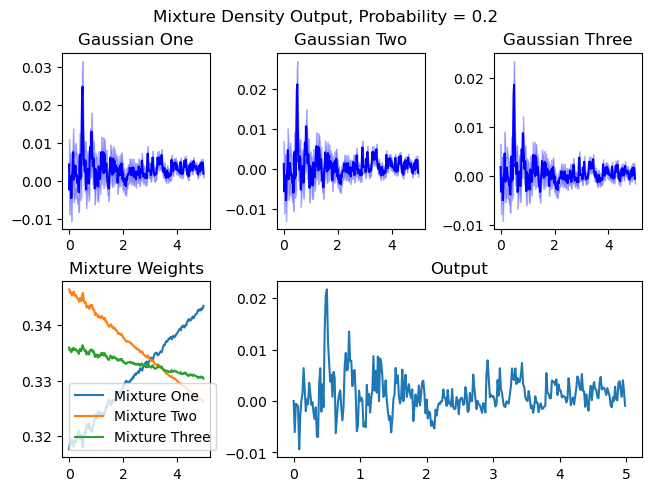

torch.Size([300, 2])


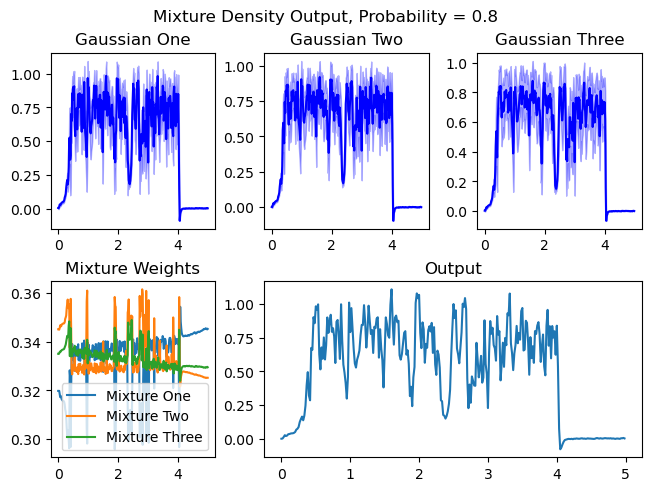

torch.Size([300, 2])


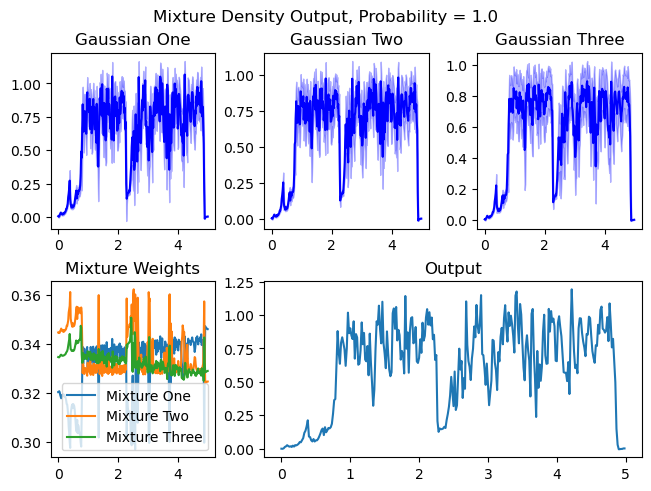

Epoch 25/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 25/64, Loss: -2.4139


Epoch 26/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 26/64, Loss: -2.5386


Epoch 27/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 27/64, Loss: -2.5826


Epoch 28/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 28/64, Loss: -2.5622


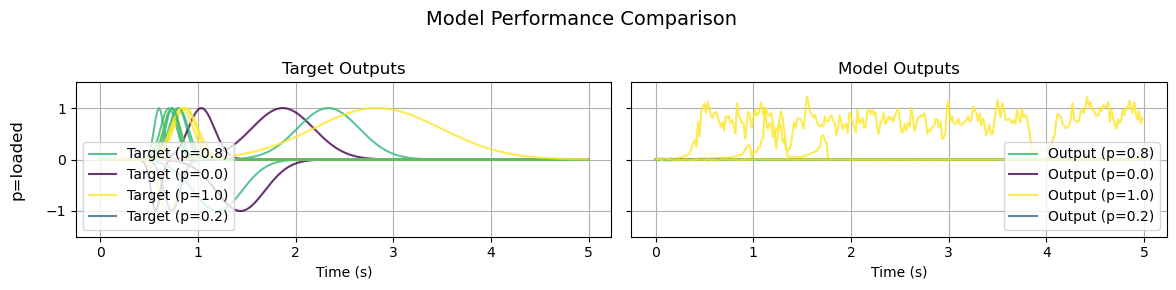

2025-06-11 18:52:42,462 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


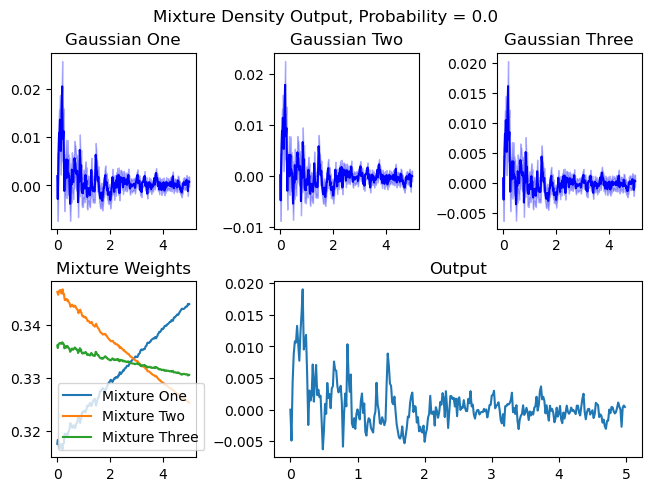

torch.Size([300, 2])


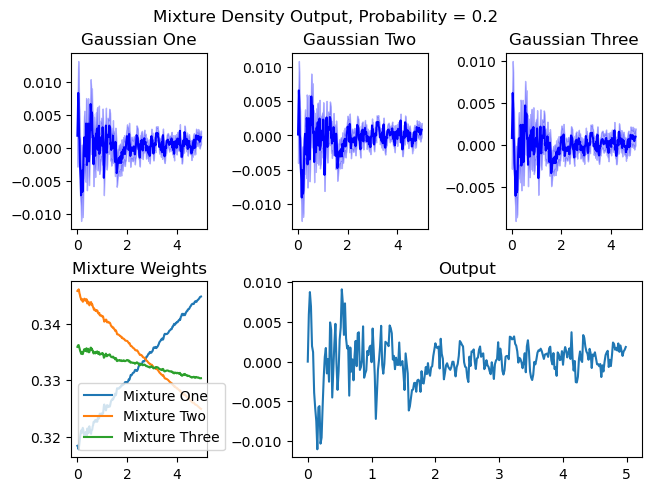

torch.Size([300, 2])


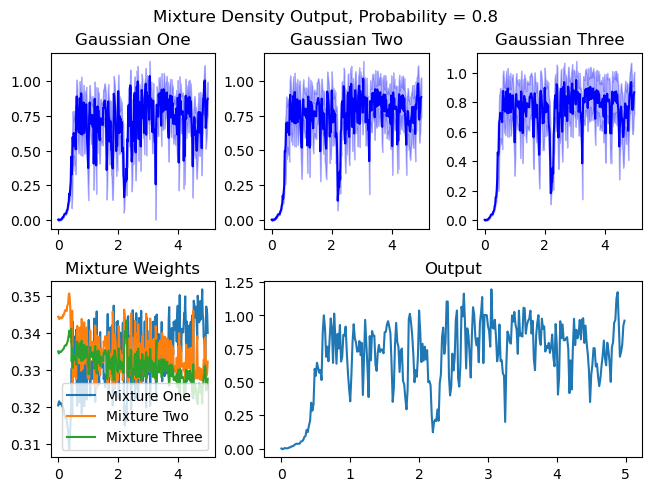

torch.Size([300, 2])


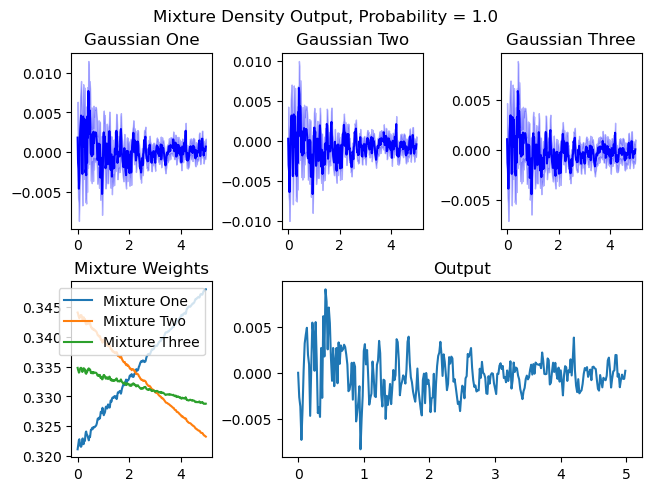

Epoch 29/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 29/64, Loss: -2.6270


Epoch 30/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 30/64, Loss: -2.6332


Epoch 31/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 31/64, Loss: -2.6280


Epoch 32/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 32/64, Loss: -2.6264


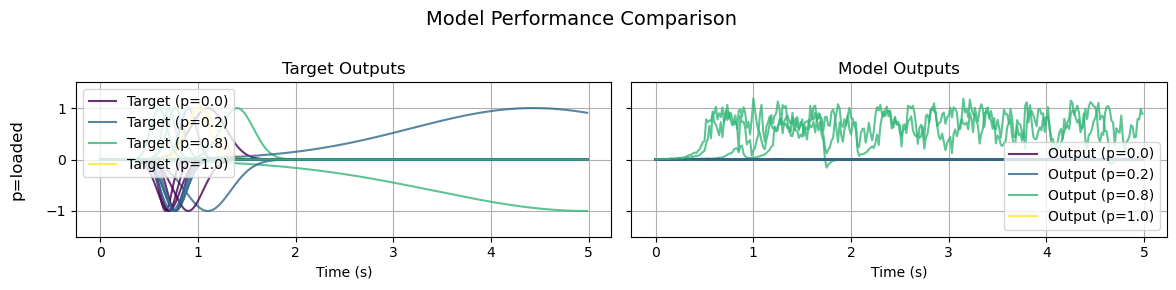

2025-06-11 18:55:10,882 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


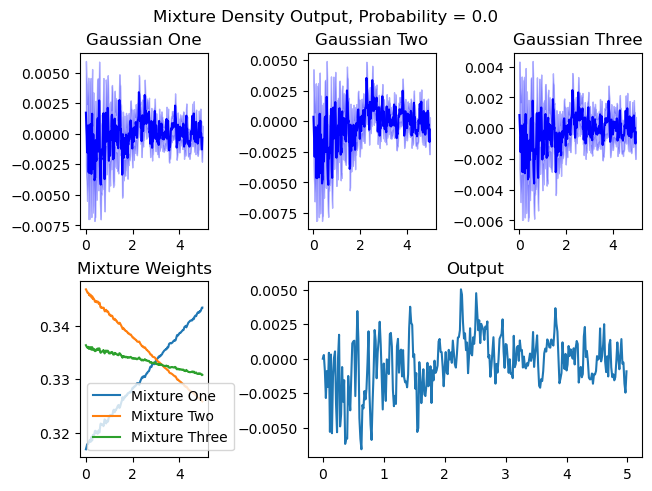

torch.Size([300, 2])


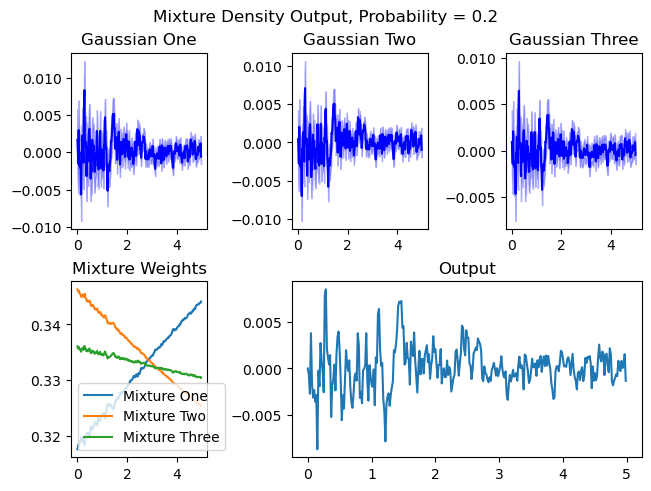

torch.Size([300, 2])


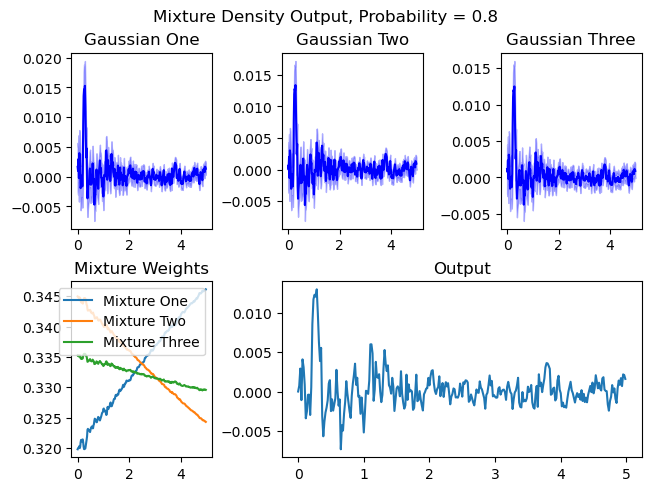

torch.Size([300, 2])


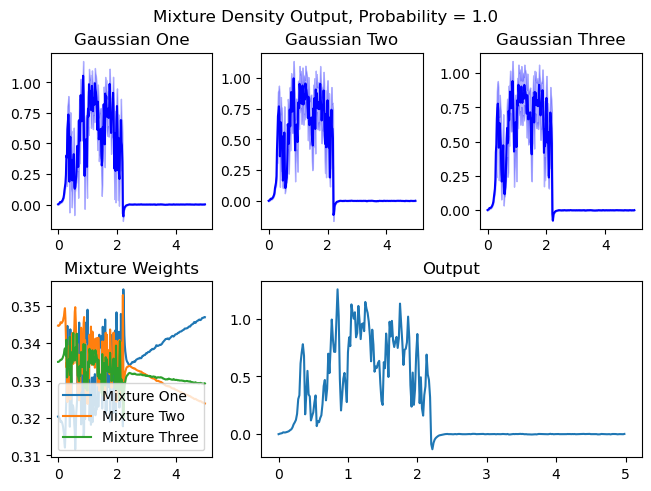

Epoch 33/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 33/64, Loss: -0.2676


Epoch 34/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 34/64, Loss: -1.3314


Epoch 35/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 35/64, Loss: -1.9730


Epoch 36/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 36/64, Loss: -2.1696


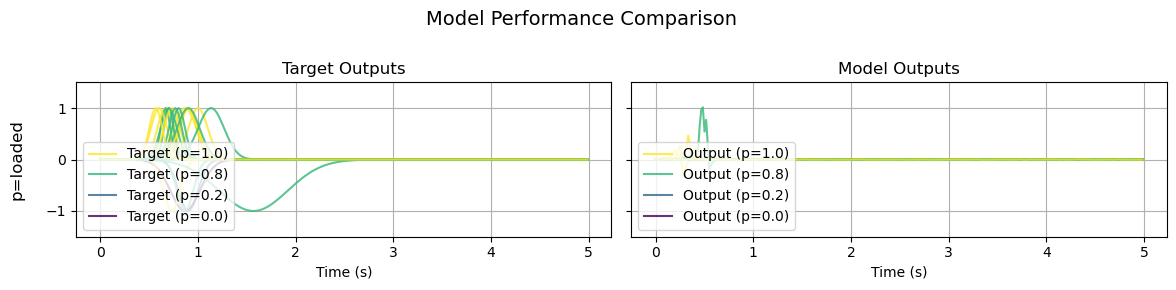

2025-06-11 18:57:41,818 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


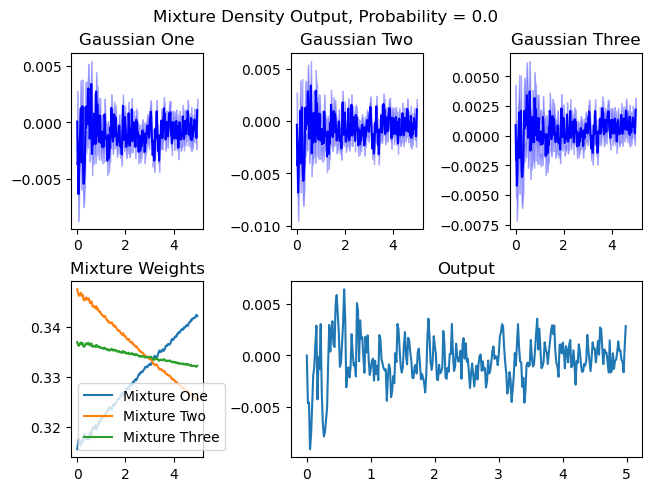

torch.Size([300, 2])


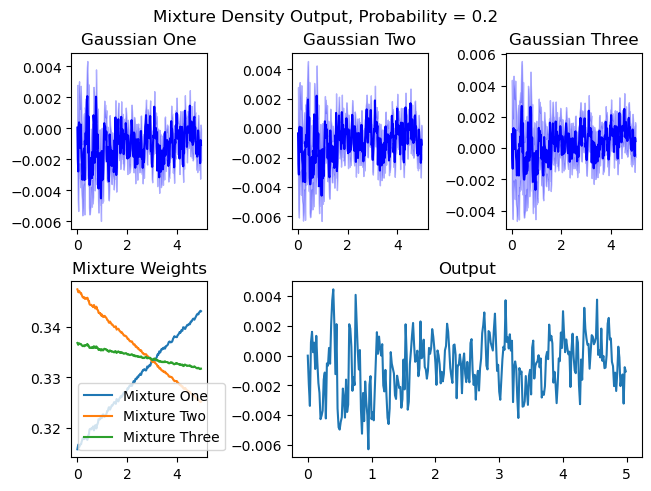

torch.Size([300, 2])


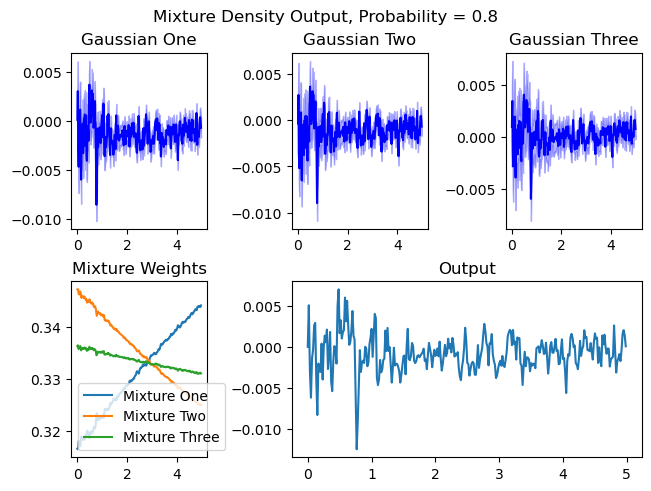

torch.Size([300, 2])


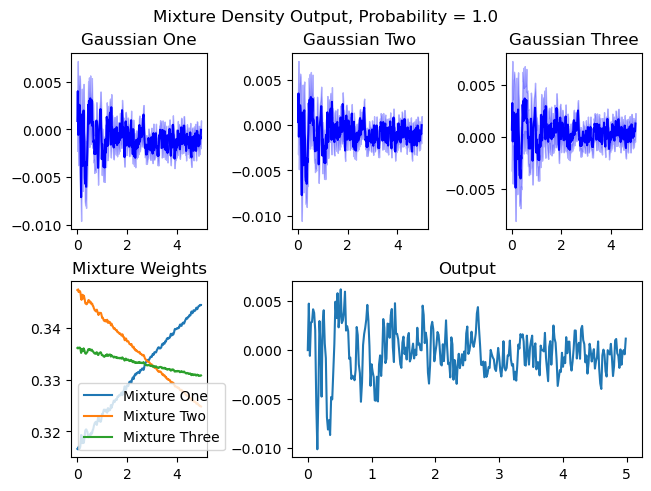

Epoch 37/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 37/64, Loss: -1.6539


Epoch 38/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 38/64, Loss: -2.3646


Epoch 39/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 39/64, Loss: -2.4422


Epoch 40/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 40/64, Loss: -2.2493


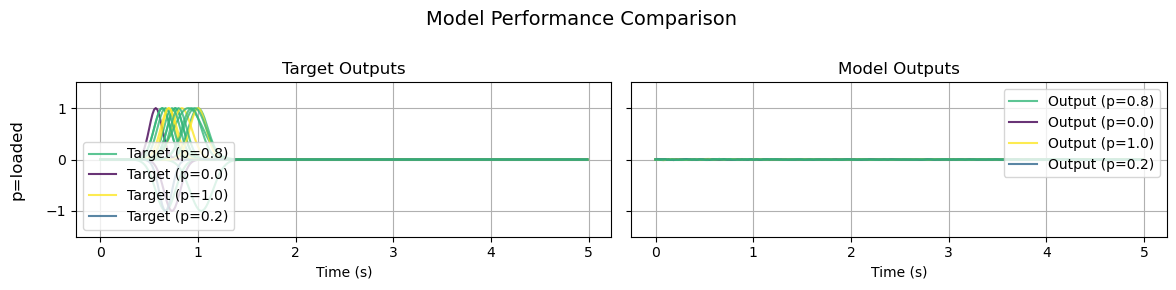

2025-06-11 19:00:13,387 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


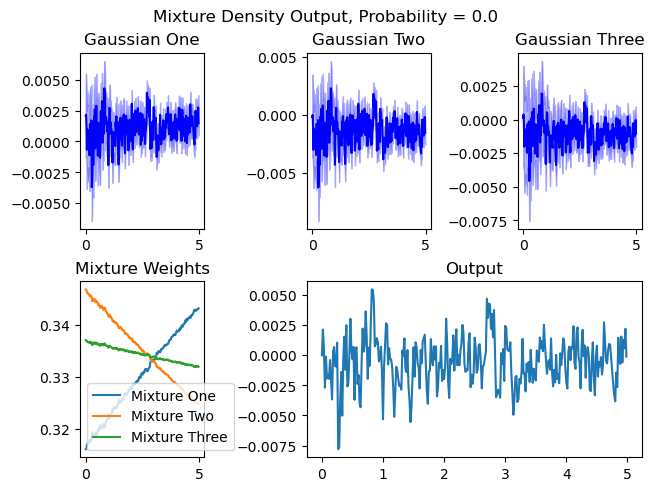

torch.Size([300, 2])


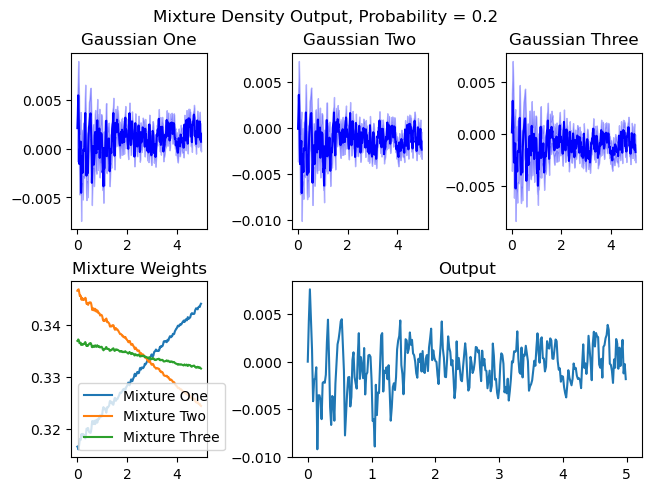

torch.Size([300, 2])


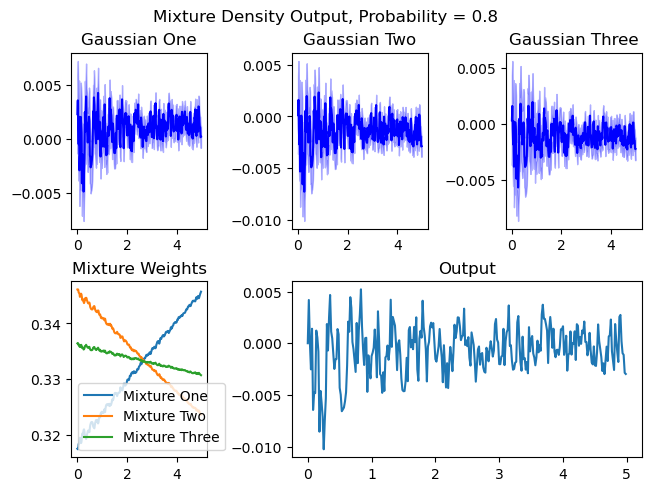

torch.Size([300, 2])


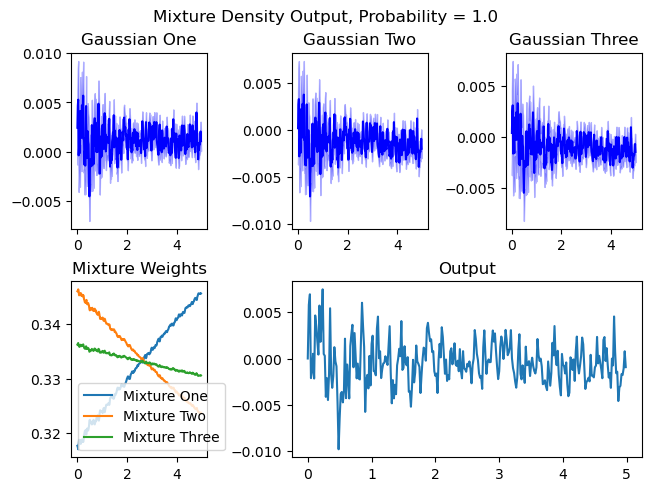

Epoch 41/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 41/64, Loss: -2.3000


Epoch 42/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 42/64, Loss: -2.2019


Epoch 43/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 43/64, Loss: -2.1262


Epoch 44/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 44/64, Loss: -2.3698


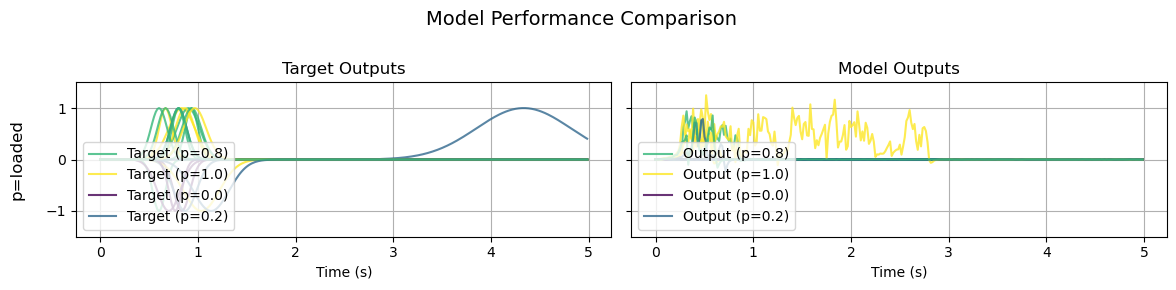

2025-06-11 19:02:51,186 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


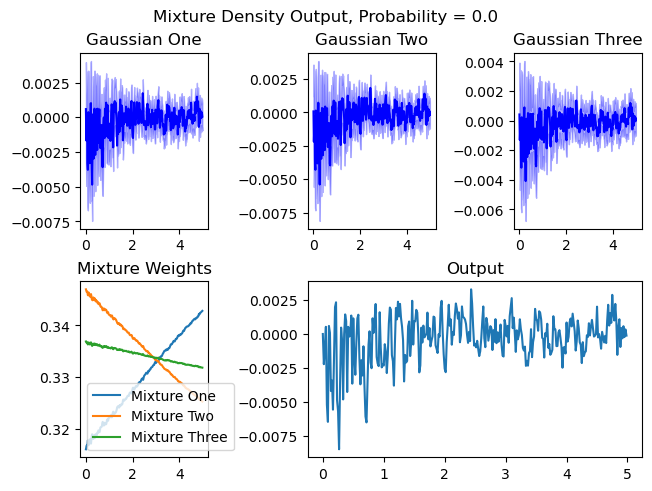

torch.Size([300, 2])


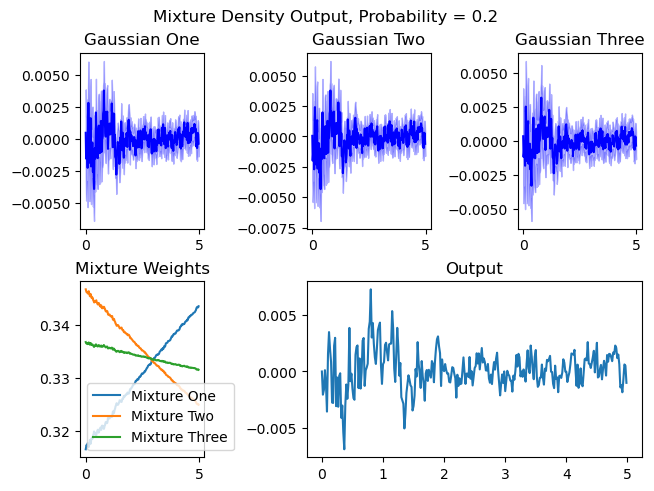

torch.Size([300, 2])


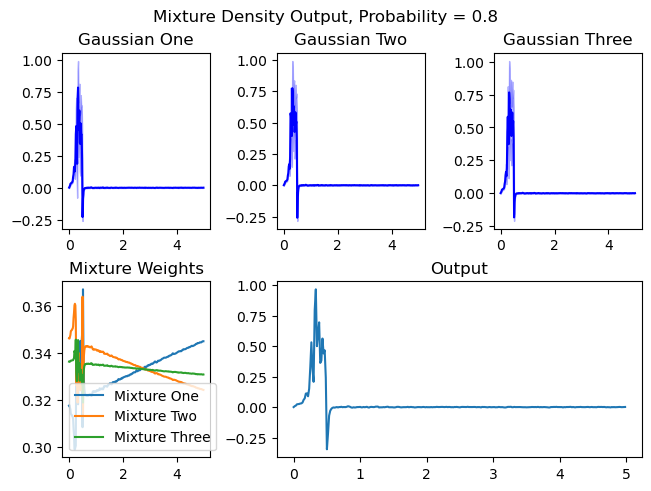

torch.Size([300, 2])


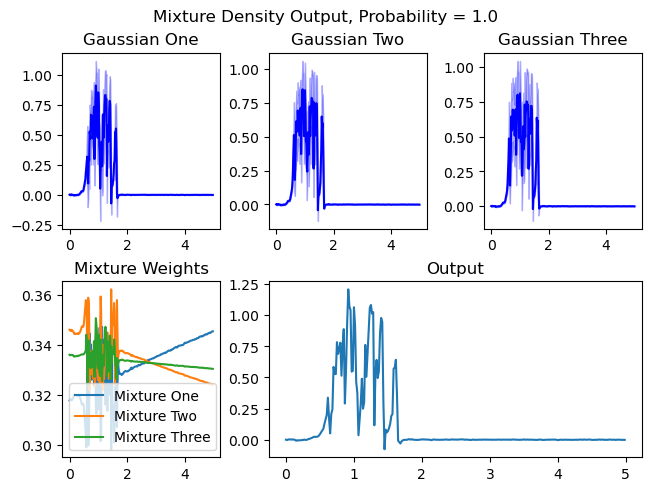

Epoch 45/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 45/64, Loss: -2.4532


Epoch 46/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 46/64, Loss: -2.4327


Epoch 47/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 47/64, Loss: -2.4240


Epoch 48/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 48/64, Loss: -2.4090


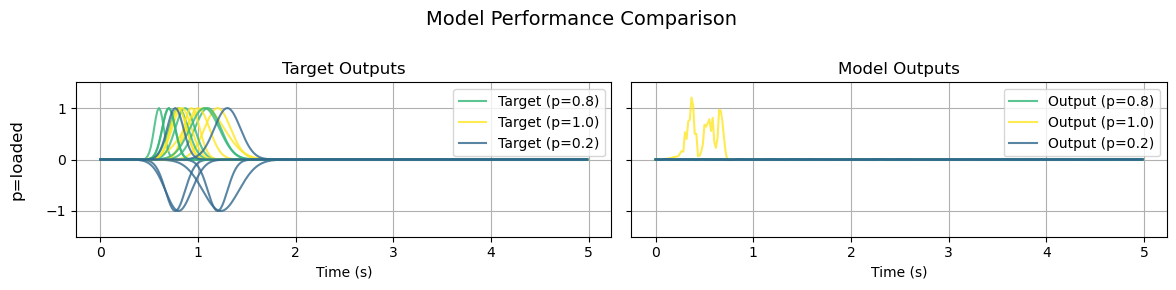

2025-06-11 19:05:29,002 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


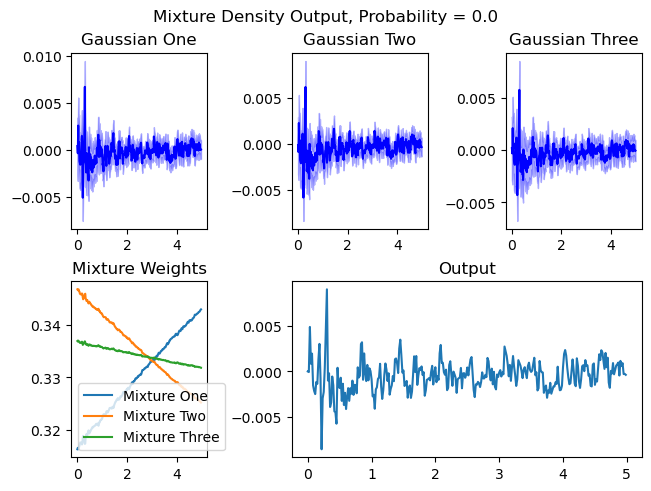

torch.Size([300, 2])


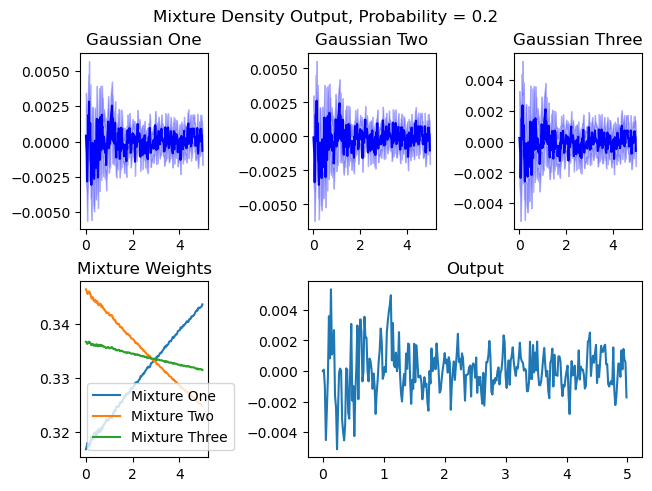

torch.Size([300, 2])


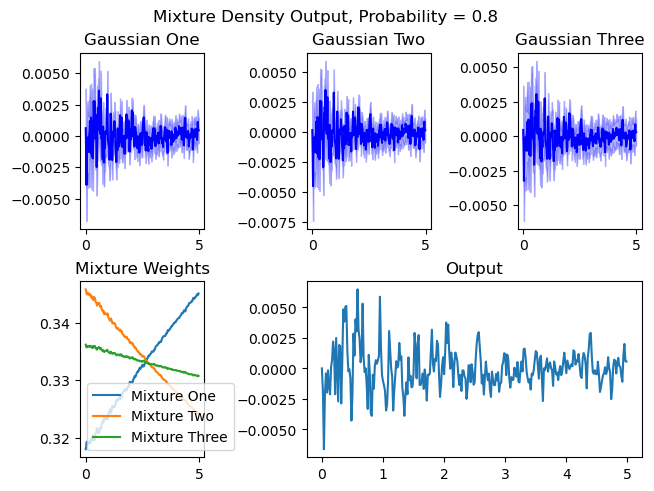

torch.Size([300, 2])


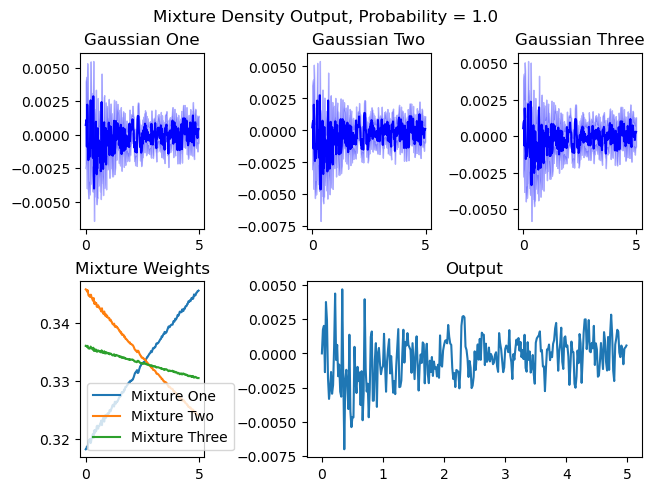

Epoch 49/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 49/64, Loss: 1.5955


Epoch 50/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 50/64, Loss: -1.3649


Epoch 51/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 51/64, Loss: -1.7925


Epoch 52/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 52/64, Loss: -1.6862


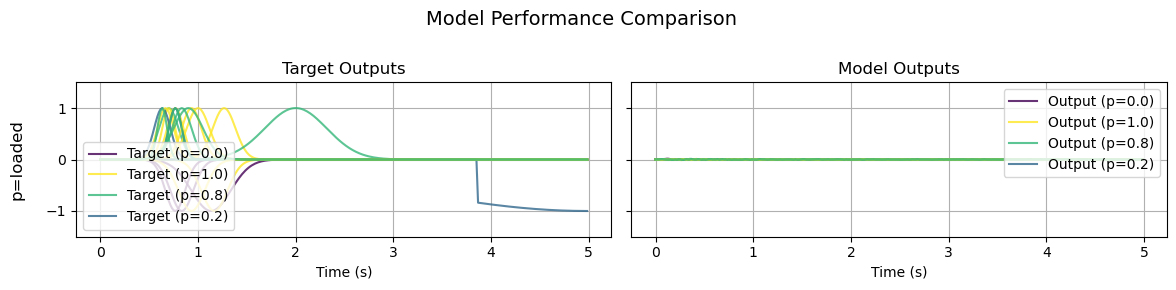

2025-06-11 19:08:08,258 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


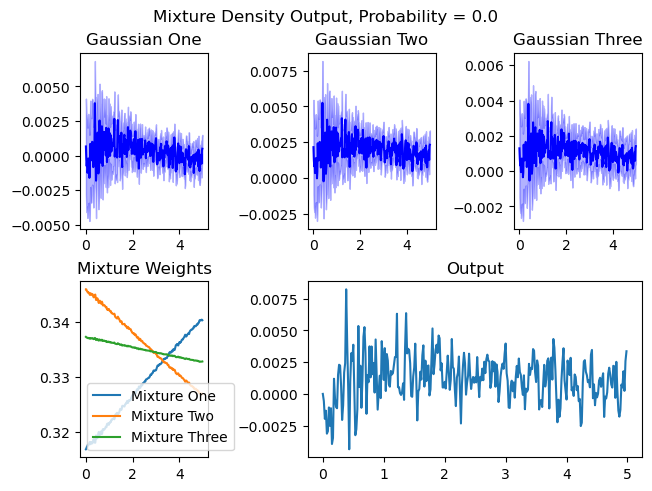

torch.Size([300, 2])


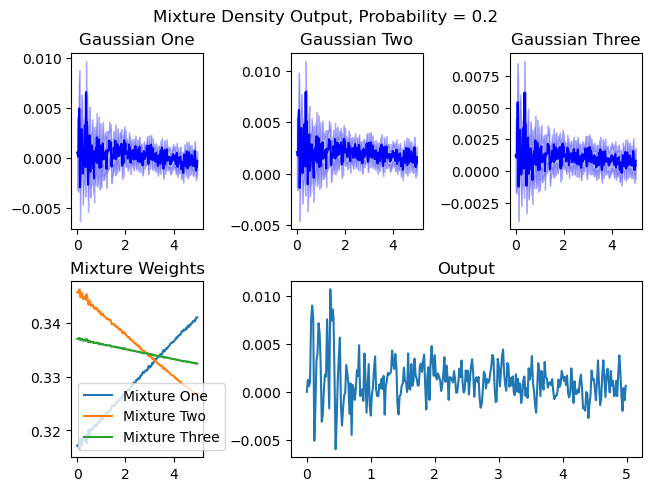

torch.Size([300, 2])


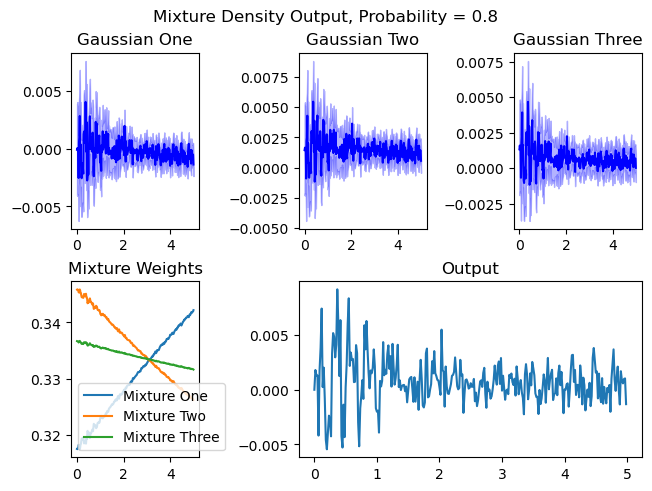

torch.Size([300, 2])


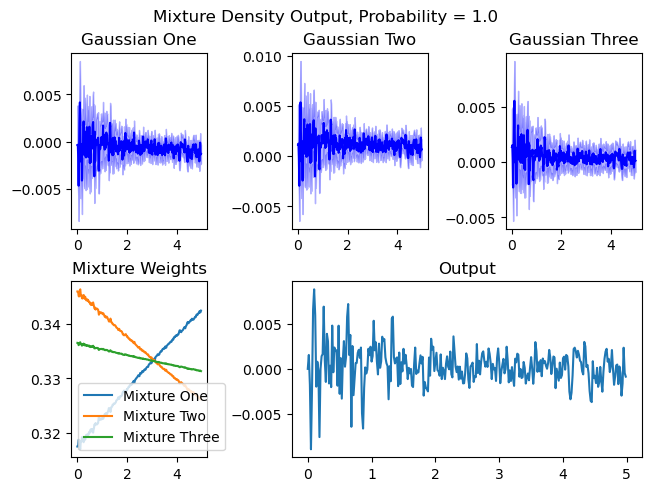

Epoch 53/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 53/64, Loss: -1.6787


Epoch 54/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 54/64, Loss: -1.7701


Epoch 55/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 55/64, Loss: -1.8870


Epoch 56/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 56/64, Loss: -1.7188


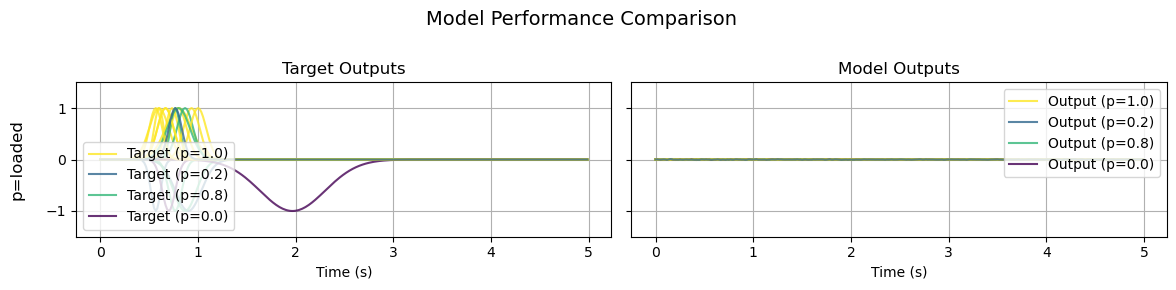

2025-06-11 19:10:48,069 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


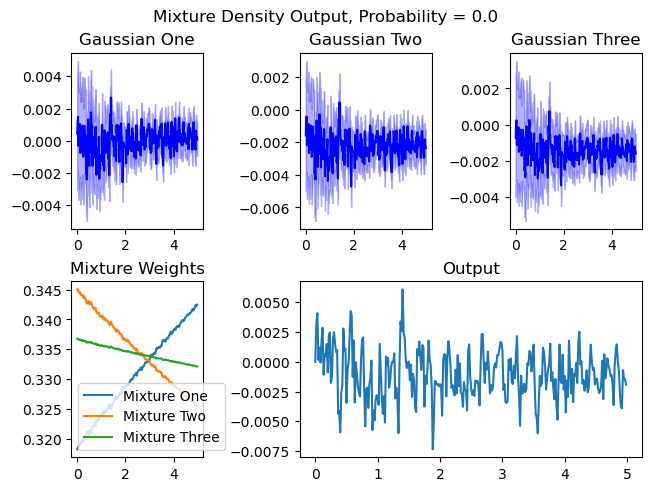

torch.Size([300, 2])


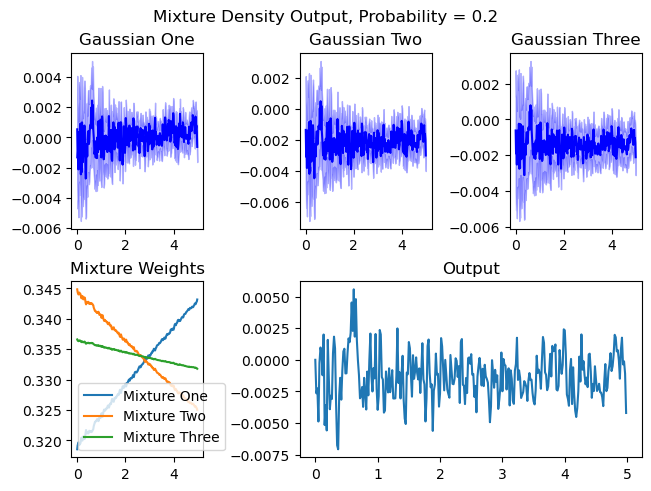

torch.Size([300, 2])


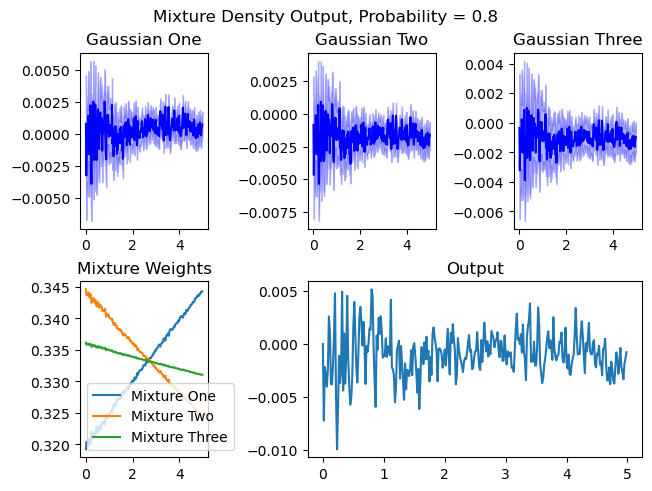

torch.Size([300, 2])


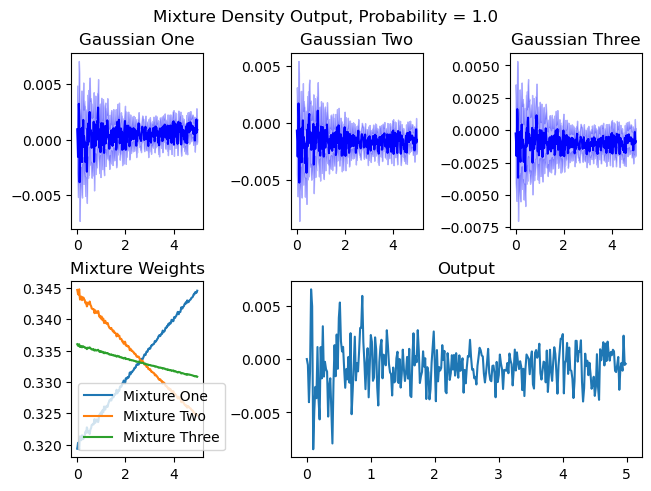

Epoch 57/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 57/64, Loss: -1.8061


Epoch 58/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 58/64, Loss: -1.8554


Epoch 59/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 59/64, Loss: -1.8175


Epoch 60/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 60/64, Loss: -1.8715


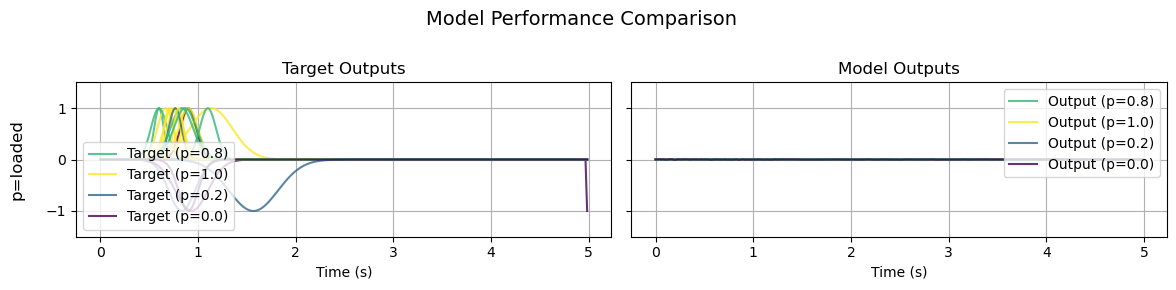

2025-06-11 19:13:29,129 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


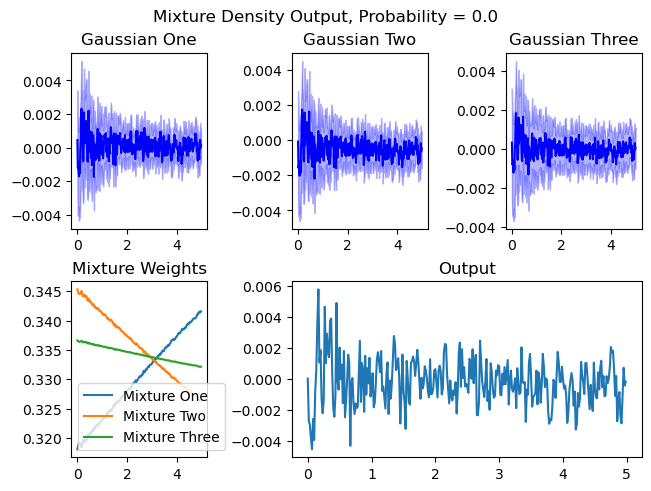

torch.Size([300, 2])


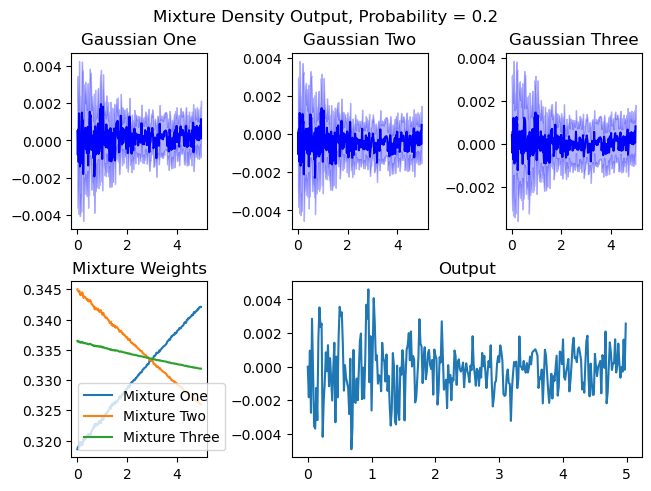

torch.Size([300, 2])


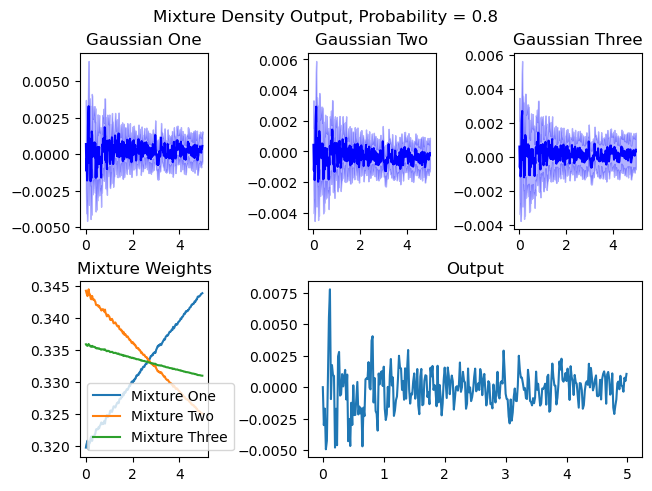

torch.Size([300, 2])


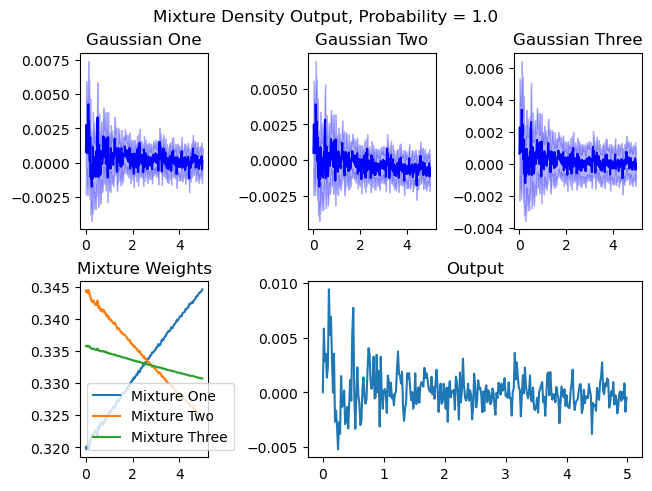

Epoch 61/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 61/64, Loss: -1.8509


Epoch 62/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 62/64, Loss: -1.7726


Epoch 63/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 63/64, Loss: -1.6459


Epoch 64/64:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 64/64, Loss: -1.5530


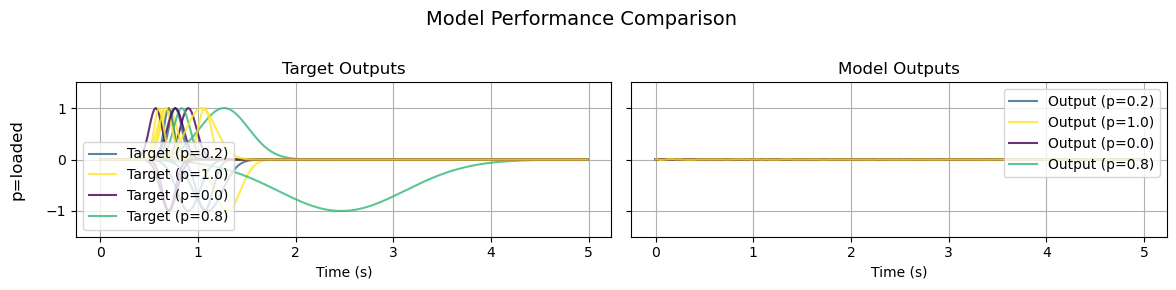

2025-06-11 19:16:08,826 - INFO - Initialized Dataset in GENERATE mode with 64 samples.


torch.Size([300, 2])


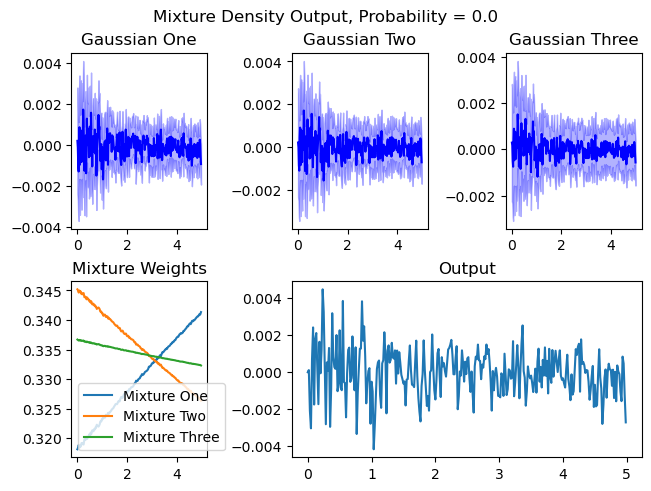

torch.Size([300, 2])


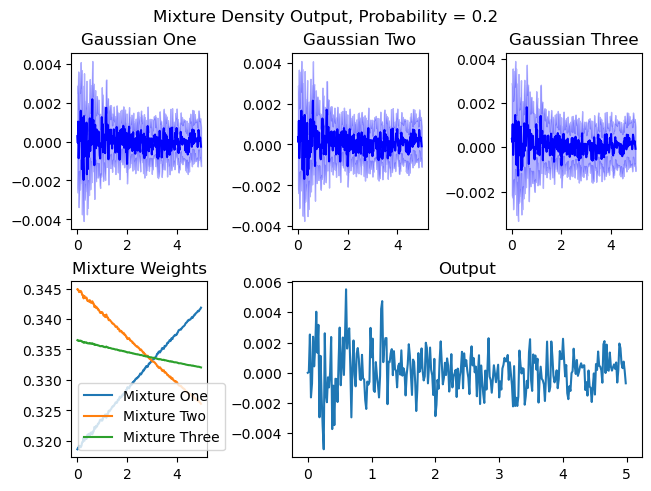

torch.Size([300, 2])


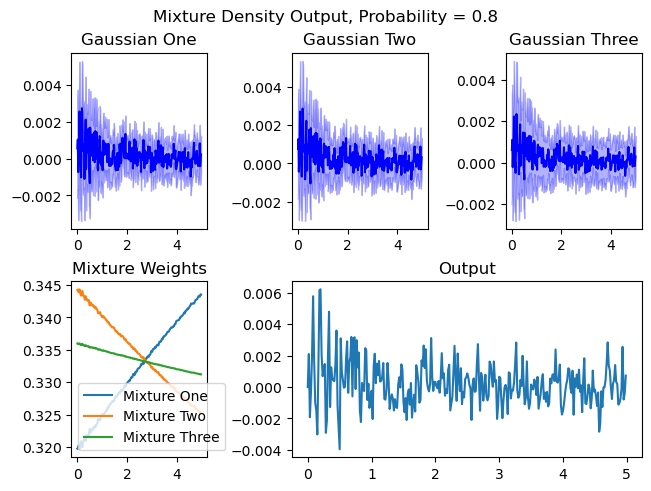

torch.Size([300, 2])


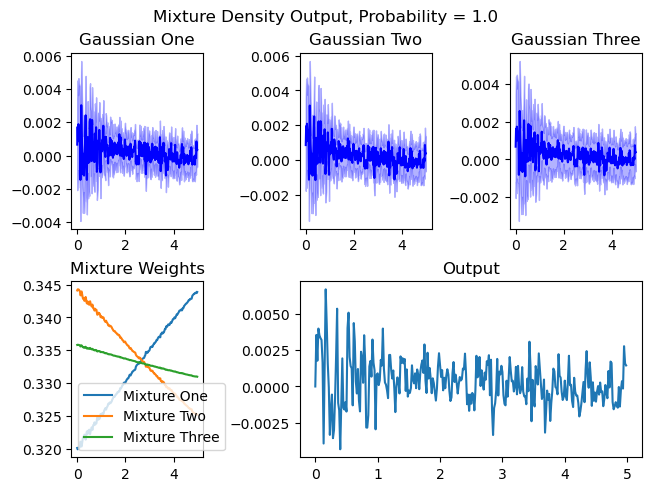

Training Complete!


In [5]:
model = rmdn.RMDN(TRAINING_PARAMS['hidden_size'], 
                  input_size=2)

if device != 'cpu':
    model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=TRAINING_PARAMS['initial_learning_rate'],
                              betas=(0.99, 0.999),
                              weight_decay=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=16)

epoch_progress = tqdm(range(TRAINING_PARAMS['num_epochs']), 
                      desc="Training Progress", 
                      position=0, 
                      leave=True)

for epoch in epoch_progress:
    epoch_loss = 0
    
    progress_bar = tqdm(dataloader, 
                        desc=f"Epoch {epoch+1}/{TRAINING_PARAMS['num_epochs']}", 
                        position=1, 
                        leave=False)

    for inputs, targets, _ in progress_bar: # three return values for load mode, two for generate
        optimizer.zero_grad()

        if device != 'cpu':
            inputs, targets = inputs.to(device, non_blocking=True), targets.unsqueeze(-1).to(device, non_blocking=True)

        # Forward Pass
        pi, mu, sigma, h_states = model(inputs, epoch, TRAINING_PARAMS['num_epochs'], train=True, outputs=targets)
        loss = rmdn.mdn_loss(pi, mu, sigma, targets)
        
        # Backward Pass
        loss.backward()
        
        # Optimization Step
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch + 1}/{TRAINING_PARAMS['num_epochs']}, Loss: {epoch_loss / len(dataloader):.4f}")

    if (epoch + 1) % 4 == 0:
        #utils.visualize_performance(model, dataset, [0.0, 0.2, 0.8, 1.0], 5)
        utils.visualize_performance(model, dataset, None, 20) # Use for loaded dataset

        with torch.no_grad():
            model.eval()
            viz_dataset = decision_dataset.DecisionDataset(generate=True, num_samples=64)
            for p in [0.0, 0.2, 0.8, 1.0]:
                inputs, _ = viz_dataset.__getitem__(index=None, p=p)
                print(inputs.shape)
                inputs = inputs.unsqueeze(0)
                pi, mu, sigma, output = model(inputs, train=False)
                visualize_mixture_components(pi, mu, sigma, output, viz_dataset.time, p)

    if (epoch + 1) % 8 == 0:
        weights_name = f'weights/model_weights_epoch_{epoch + 1}_hidden_size_32_experimental'
        torch.save(model.state_dict(), weights_name) # experimental data + linear ramp

print("Training Complete!")